In [1]:
#Some installations will be needed in order to run this code

import numpy as np
import matplotlib.pyplot as plt
import json


import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from shapely.geometry import shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon

import requests
import geojson
from pyproj import CRS
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService

import scipy.stats as stats
from scipy.signal import lfilter

import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

## Welcome to my attempt at statistics
We start with reading in, and processing, the data from Montreal

In [2]:
#Read data into panda
df = pd.read_json(r"trip5000.json")

In [3]:
#Read the data as a geodataframe
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:4617') 
#gdf.plot(alpha=0.1,figsize=(8, 8))

### Original data:
* geometry: LINESTRING og coordinates for trip
* stop: stopping time for trip
* id_origine: trip id number
* start: start time for trip
* length: length of trip
* purpse: repported purpose of trip
* liste_segments_jsonb: I believe this is an attempt to classify the type of road. See data documentation for more
* n_coord: number of recorded coordinates
* id: trips id number

In [5]:
gdf.head(3)

geometry                 stop  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...  2013-06-25 16:34:16   
1  LINESTRING (-73.62897 45.46372, -73.62891 45.4...  2013-07-25 14:40:06   
2  LINESTRING (-73.58481 45.56786, -73.58153 45.5...  2013-07-25 14:43:12   

   id_origine                start  length  purpose  \
0          52  2013-06-25 16:21:21    3163  Commute   
1        2325  2013-07-25 14:37:42    1066  Courses   
2        2326  2013-07-25 14:19:15    5619  Courses   

                                liste_segments_jsonb  n_coord    id  
0  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511    52  
1  [{'source': 'GEOBASE', 'id': 1310311}, {'sourc...      196  2325  
2  [{'source': 'GEOBASE', 'id': 1170061}, {'sourc...     1036  2326

### Convert each trip into segments
* Here we split each linestring into a multilinestring of individual segments [a, b, c] -> [(c,a), (a,b), (b,c)]
* this also means that the first element needs to be deleted
* It takes like 10 minutes but it is by far the fasted method i've found
* Further down we save this version so we wont have to repeat this step again

In [6]:
#Create a list of points from linestring (geometry)
gdf['points'] = gdf.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

gdf["duration"] = (gdf['stop'].apply(pd.to_datetime) - gdf['start'].apply(pd.to_datetime)) / pd.Timedelta(seconds=1)
gdf["geo"] = gdf.apply(lambda x: MultiLineString([LineString([x['geometry'].coords[i-1], x['geometry'].coords[i]]) for i in range(len(x['geometry'].coords))]),axis=1)

#Make that into the geometry
gdf.set_geometry("geo", drop=False, inplace=True, crs='epsg:4617')
#And explode it based on geo
gdf = gdf.explode(index_parts=True)
gdf.dropna(inplace=True)

In [7]:
# Since each short segment is now its "own trip" we need to do some re-indexing
# trip_id will be the index for the trip
# and idd will be the index of the segment in the trip
gdf["idd"] = [x for x in range(len(gdf))]
gdf.set_index(["idd"], inplace=True,
             append=True, drop=False)
gdf.drop("idd",axis=1, inplace=True)
gdf.reset_index(level=0,inplace=True)
gdf.rename(columns={"level_0":"trip_id"}, inplace=True)
gdf.reset_index(level=0,inplace=True)
gdf.drop("level_0", axis=1, inplace=True)

In [8]:
gdf.head(3)
# gdf.loc[gdf["trip_id"] == 4].head(3) # look at trip 4

trip_id                                           geometry  \
idd                                                               
0          0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
1          0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
2          0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   

                    stop  id_origine                start  length  purpose  \
idd                                                                          
0    2013-06-25 16:34:16          52  2013-06-25 16:21:21    3163  Commute   
1    2013-06-25 16:34:16          52  2013-06-25 16:21:21    3163  Commute   
2    2013-06-25 16:34:16          52  2013-06-25 16:21:21    3163  Commute   

                                  liste_segments_jsonb  n_coord  id  \
idd                                                                   
0    [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
1    [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
2    [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   

                                                points  duration  \
idd                                                                
0    [(-73.577476909289, 45.5069002299392), (-73.57...     775.0   
1    [(-73.577476909289, 45.5069002299392), (-73.57...     775.0   
2    [(-73.577476909289, 45.5069002299392), (-73.57...     775.0   

                                                   geo  
idd                                                     
0    LINESTRING (-73.60445 45.51966, -73.57748 45.5...  
1    LINESTRING (-73.57748 45.50690, -73.57751 45.5...  
2    LINESTRING (-73.57751 45.50692, -73.57757 45.5...

### save point
Since the above takes a little time, I decided to copy gdf and keep working with that instead. So if we want to change anything fundamental, we can come back to this point and re-copy gdf. It might be moot now, but at least you know why :)
\
\
We also add the length of each segment. To do this we project the crs ESPG:4617 which is in degrees, to a metric crs ESPG:3979. 
* https://epsg.io/3979
* https://epsg.io/4617

In [9]:
GM = gdf.copy()
GM["length"] = gdf["geo"].to_crs("EPSG:3979").length

In [10]:
GM.head(3)

trip_id                                           geometry  \
idd                                                               
0          0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
1          0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
2          0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   

                    stop  id_origine                start       length  \
idd                                                                      
0    2013-06-25 16:34:16          52  2013-06-25 16:21:21  2578.232646   
1    2013-06-25 16:34:16          52  2013-06-25 16:21:21     3.259530   
2    2013-06-25 16:34:16          52  2013-06-25 16:21:21    11.615175   

     purpose                               liste_segments_jsonb  n_coord  id  \
idd                                                                            
0    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
1    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
2    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   

                                                points  duration  \
idd                                                                
0    [(-73.577476909289, 45.5069002299392), (-73.57...     775.0   
1    [(-73.577476909289, 45.5069002299392), (-73.57...     775.0   
2    [(-73.577476909289, 45.5069002299392), (-73.57...     775.0   

                                                   geo  
idd                                                     
0    LINESTRING (-73.60445 45.51966, -73.57748 45.5...  
1    LINESTRING (-73.57748 45.50690, -73.57751 45.5...  
2    LINESTRING (-73.57751 45.50692, -73.57757 45.5...

### A question about time
Since the time-stamps are missing from this data-set, and this choice can have a great effect on the results we define two different "times"
* ind_time: [s/1] calculated average time between readings (total time of trip/number of readings in trip)
* time; mean time between GPS readings (set to round(1.51) seconds for all readings)

In [11]:
GM["time"] = 1.5
GM["vel_og"] = GM["length"]/GM["time"]
GM["ind_time"] = GM["duration"]/GM["n_coord"]
GM["ind_vel"] = GM["length"]/GM["ind_time"]

In [12]:
GM.dropna(inplace=True) #remove NaN-values (in this case it is one trip that is deleted (i think like trip 938 or smth))

In [13]:
GM.reset_index(inplace=True)
GM.drop(["idd","geometry","stop", "id_origine", "start", "purpose", "liste_segments_jsonb","n_coord", "id", "points","duration"], axis=1, inplace=True)
GM_ind = GM[["trip_id", "length", "ind_vel","ind_time"]].copy()
GM_ind.rename(columns = {'ind_time':'time'}, inplace = True)
GM_ind.rename(columns = {'ind_vel':'vel_og'}, inplace = True)
GM.drop("ind_time", axis=1, inplace=True)
GM.drop("ind_vel", axis=1, inplace=True)

# Done

Meet your dataframes:
### GM:
* index
* trip_id; to keep track of what trip it belongs to
* length; [m] length of linesegment
* geo; two coordinates denoting a linesegment
* time = mean time; mean time between GPS readings (set to 1.51 seconds for all readings)
* vel_og; [m/s] velocity as calculated based on mean time

### GM_ind:
* index
* trip_id; to keep track of what trip it belongs to
* length; [m] length of linesegment
* time = ind_time; [s/1] calculated average time between readings (total time of trip/number of readings in trip)
* vel_og = ind_vel; [m/s] velocity as calculated based on ind_time


In [14]:
GM.head(2)

trip_id       length                                                geo  \
0        0  2578.232646  LINESTRING (-73.60445 45.51966, -73.57748 45.5...   
1        0     3.259530  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   

   time       vel_og  
0   1.5  1718.821764  
1   1.5     2.173020

In [15]:
GM_ind.head(2) #print dataframe

trip_id       length       vel_og      time
0        0  2578.232646  1699.970171  1.516634
1        0     3.259530     2.149187  1.516634

# Let's do some statistics 
Everything will be done on both dataframes, but I will only print out GM unless comparison is relevant. First we need to get rid of some infeasible velocities

In [16]:
#The 5 highest velocities
GM["vel_og"].nlargest(5).tolist()

[25271.901090650557,
 18927.691969429154,
 18345.71016298614,
 18345.71016298614,
 18285.423599597696]

## Z-score
We want to use z-score to exclude some data-points (based on how much the velocity in that point deviates from the mean velocity of that trip). 
The question is which points to include when calculating the mean

We exclude the points which we consider "standing still" (v<1m/s)
we also exclude all velocities over 20m/s
for comparison we can also choose m_v to something else, to see how much effect the choice of 20m/s as cutoff has (very little).

In [17]:
max_v = 20 #exclude velocities over max_v when calculating z-score
min_v = 1 #exclude velocities under min_v when calculating z-score
name = "Z_val_"+str(max_v)

GM[name] = np.nan #create new "empty" column

GM.loc[(GM["vel_og"]> max_v), name] = 1000 
GM.loc[(GM["vel_og"]< min_v), name] = 0
GM.loc[(GM["vel_og"]<= max_v)&(GM["vel_og"] >=min_v), name]= GM.loc[(GM["vel_og"]< max_v)&(GM["vel_og"] >=min_v)].groupby("trip_id")["vel_og"].apply(stats.zscore).tolist()



In [18]:
#do the same for GM_ind 
max_v = 20 #exclude velocities over max_v when calculating z-score
min_v = 1 #exclude velocities under min_v when calculating z-score
name = "Z_val_"+str(max_v)

GM_ind[name] = np.nan #create new "empty" column

GM_ind.loc[(GM_ind["vel_og"]> max_v), name] = 1000 
GM_ind.loc[(GM_ind["vel_og"]< min_v), name] = 0
GM_ind.loc[(GM_ind["vel_og"]<= max_v)&(GM_ind["vel_og"] >=min_v), name]= GM_ind.loc[(GM_ind["vel_og"]< max_v)&(GM_ind["vel_og"] >=min_v)].groupby("trip_id")["vel_og"].apply(stats.zscore).tolist()



## Comparison between cut-off-Z's

We set
* Z_val = 1000 if v > 20
* Z_val = 0 if v < 1

This means that when we exclude all data-points with z-val > some value, \
we automatically cut away the "too fast" speeds, but not the "standing still"
\
https://ilovebicycling.com/average-bike-speed/
\
Below we plot how the destribution of velocities changes depending on which Z-value we use as cut-off:

## Mean time = 1.5 s/segment

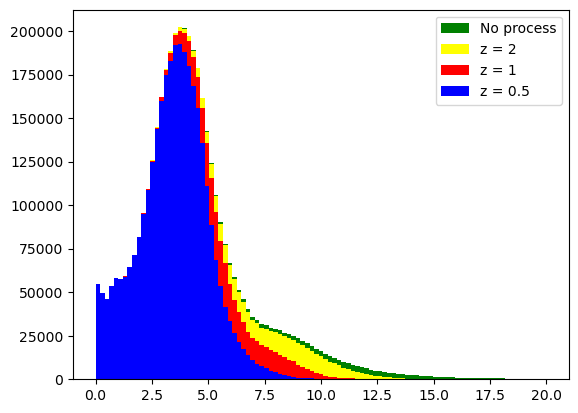

In [19]:
bins = np.linspace(0, 20, 100) #Create bins of equal size between 0 and 20

plt.hist(GM["vel_og"], label="No process", bins=bins, alpha=1, color='green')
plt.hist(GM.loc[GM["Z_val_20"]<= 2]["vel_og"], label='z = 2', bins=bins, alpha=1, color='yellow')
plt.hist(GM.loc[GM["Z_val_20"]<= 1]["vel_og"], label='z = 1', bins=bins, alpha=1, color='red')
plt.hist(GM.loc[GM["Z_val_20"]<= 0.5]["vel_og"], label='z = 0.5', bins=bins, alpha=1, color='blue')

plt.legend()
plt.show()

## Individual time

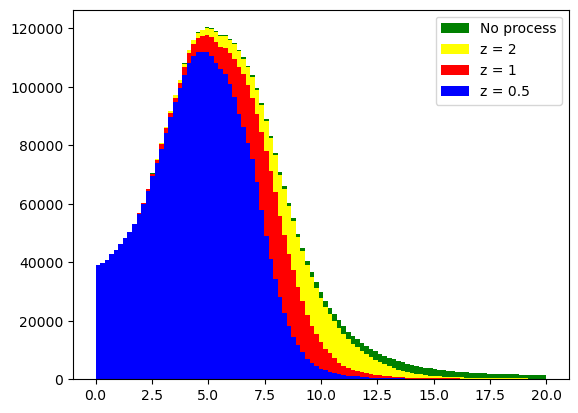

In [20]:
bins = np.linspace(0, 20, 100) #Create bins of equal size between 0 and 20

plt.hist(GM_ind["vel_og"], label="No process", bins=bins, alpha=1, color='green')
plt.hist(GM_ind.loc[GM_ind["Z_val_20"]<= 2]["vel_og"], label='z = 2', bins=bins, alpha=1, color='yellow')
plt.hist(GM_ind.loc[GM_ind["Z_val_20"]<= 1]["vel_og"], label='z = 1', bins=bins, alpha=1, color='red')
plt.hist(GM_ind.loc[GM_ind["Z_val_20"]<= 0.5]["vel_og"], label='z = 0.5', bins=bins, alpha=1, color='blue')

plt.legend()
plt.show()

In [20]:
# If you have tested other m_v (max-vel to be included in calculating z-score)
# This is how you delete those columns
#GM.drop("Z_val_50", axis=1, inplace=True)

## Replace infeasible velocities with interpolation of neighboring velocities
We copy the original velocity (vel_og) but set all velocities where z > 2 to NaN, and then use pandas.interpolate to (linear) interpolate new velocities for those points.

In [26]:
GM["vel"] = GM["vel_og"].copy()
GM.loc[GM['Z_val_20'] >= 2, 'vel'] = np.nan
GM["vel"].interpolate(method='linear', inplace=True)

#GM_ind["vel"] = GM_ind["vel_og"].copy()
#GM_ind.loc[GM_ind['Z_val_20'] >= 2, 'vel'] = np.nan
#GM_ind["vel"].interpolate(method='linear', inplace=True)

# Smoothing

Testing some different smoothing options
* Moving average
* exponential moving average
* lfilter

https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html

(these functions will behave wrong in the transition between trips, but applying them separately to each trip vs applying them to the entire dataframe is sooo much faster. So don't bother with that until you have decided on a specific smoothing function)

## why?
It's easy to see that even though we work with the data as if the time between readings is constant this is not the case. To see that this is not the case we apply a smoothing function and compare to the original (interpolated) data

In [27]:
n = 5             # larger n gives smoother curves
b = [1.0 / n] * n  # numerator coefficients
a = 1              # denominator coefficient

trip_ids = GM.trip_id.unique().tolist()

for trip_id in trip_ids:
    GM.loc[GM["trip_id"] == trip_id, "vel_smooth"] = lfilter(b,a, GM.loc[GM["trip_id"] == trip_id]["vel"])

In [ ]:
#repeat for GM_ind
trip_ids = GM_ind.trip_id.unique().tolist()

for trip_id in trip_ids:
    GM_ind.loc[GM_ind["trip_id"] == trip_id, "vel_smooth"] = lfilter(b,a, GM_ind.loc[GM_ind["trip_id"] == trip_id]["vel"])

In [24]:
trip1 = 0
trip2 = 222 #at random
one = GM.loc[GM["trip_id"] == trip1]
two = GM.loc[GM["trip_id"] == trip2]

rows = 1

## OG velocities, 
all vel with z>2 (the ones that will be removed) are marked with *

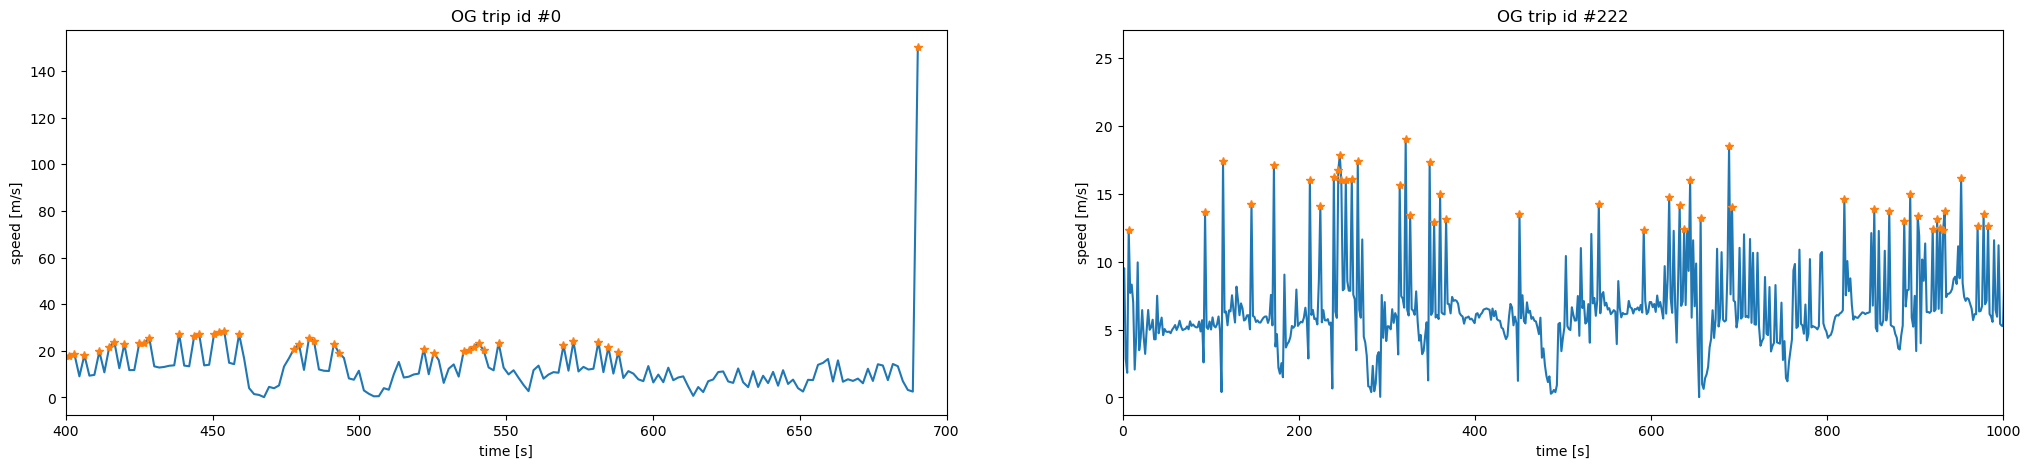

In [25]:
fig = plt.figure(figsize=(25, 5*rows))

plt.subplot(rows,2,1)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot([1.7*x for x in range(len(one["vel_og"]))], one["vel_og"], "-")
plt.plot([1.7*(x-one.index.tolist()[0]) for x in one.loc[one["Z_val_20"] >= 2].index.tolist()], one.loc[one["Z_val_20"] >= 2]["vel_og"], "*")
plt.xlim([400, 700])
plt.title("OG trip id #"+str(trip1))

plt.subplot(rows,2,2)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot([1.7*x for x in range(len(two["vel_og"]))], two["vel_og"], "-")
plt.plot([1.7*(x-two.index.tolist()[0]) for x in two.loc[two["Z_val_20"] >= 2].index.tolist()], two.loc[two["Z_val_20"] >= 2]["vel_og"], "*")
plt.xlim([0, 1000])
plt.title("OG trip id #"+str(trip2))

plt.show()

## Same as above, but zoomed in

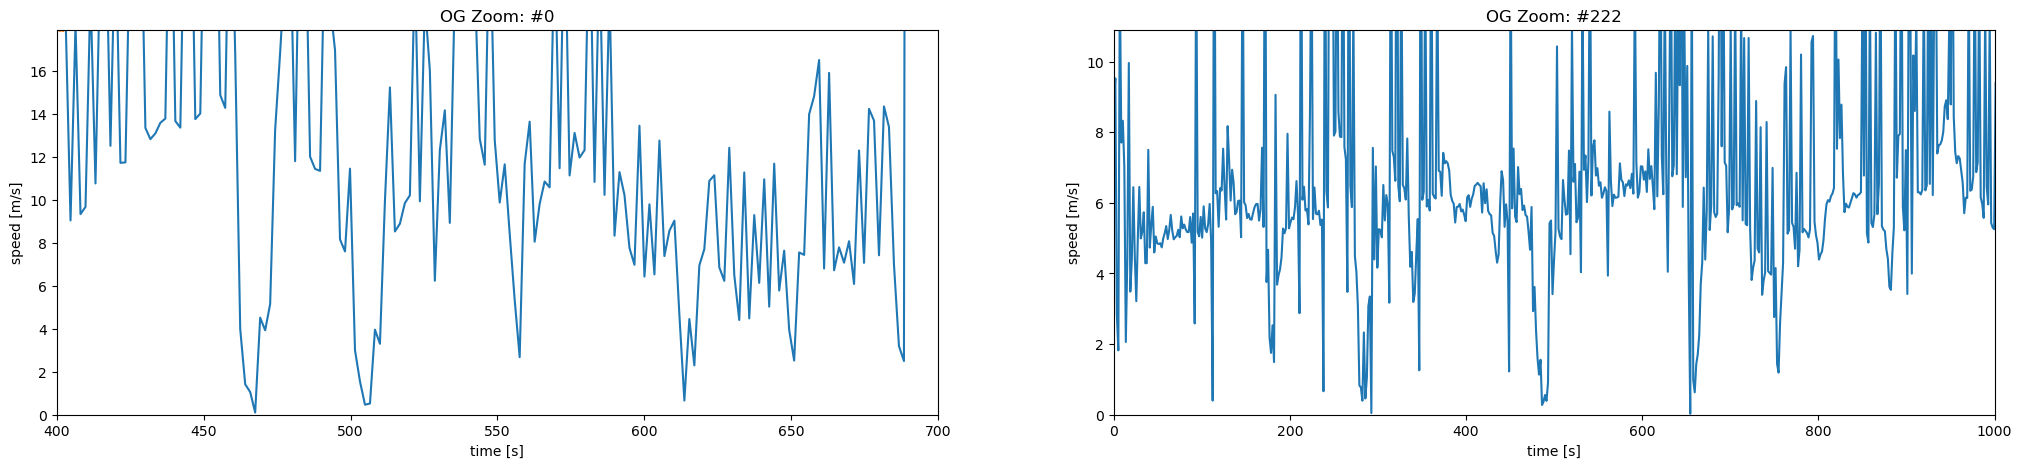

In [26]:
fig = plt.figure(figsize=(25, 5*rows))
plt.subplot(rows,2,1)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot([1.7*x for x in range(len(one["vel_og"]))], one["vel_og"], "-")
plt.plot([1.7*(x-one.index.tolist()[0]) for x in one.loc[one["Z_val_20"] >= 2].index.tolist()], one.loc[one["Z_val_20"] >= 2]["vel_og"], "*")
plt.xlim([400, 700])
plt.ylim([0,17.9])
plt.title("OG Zoom: #"+str(trip1))

plt.subplot(rows,2,2)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot([1.7*x for x in range(len(two["vel_og"]))], two["vel_og"], "-")
plt.plot([1.7*(x-two.index.tolist()[0]) for x in two.loc[two["Z_val_20"] >= 2].index.tolist()], two.loc[two["Z_val_20"] >= 2]["vel_og"], "*")
plt.xlim([0, 1000])
plt.ylim([0,10.9])
plt.title("OG Zoom: #"+str(trip2))
plt.show()

## Infeasible velocities removed
and linear interpolation applied

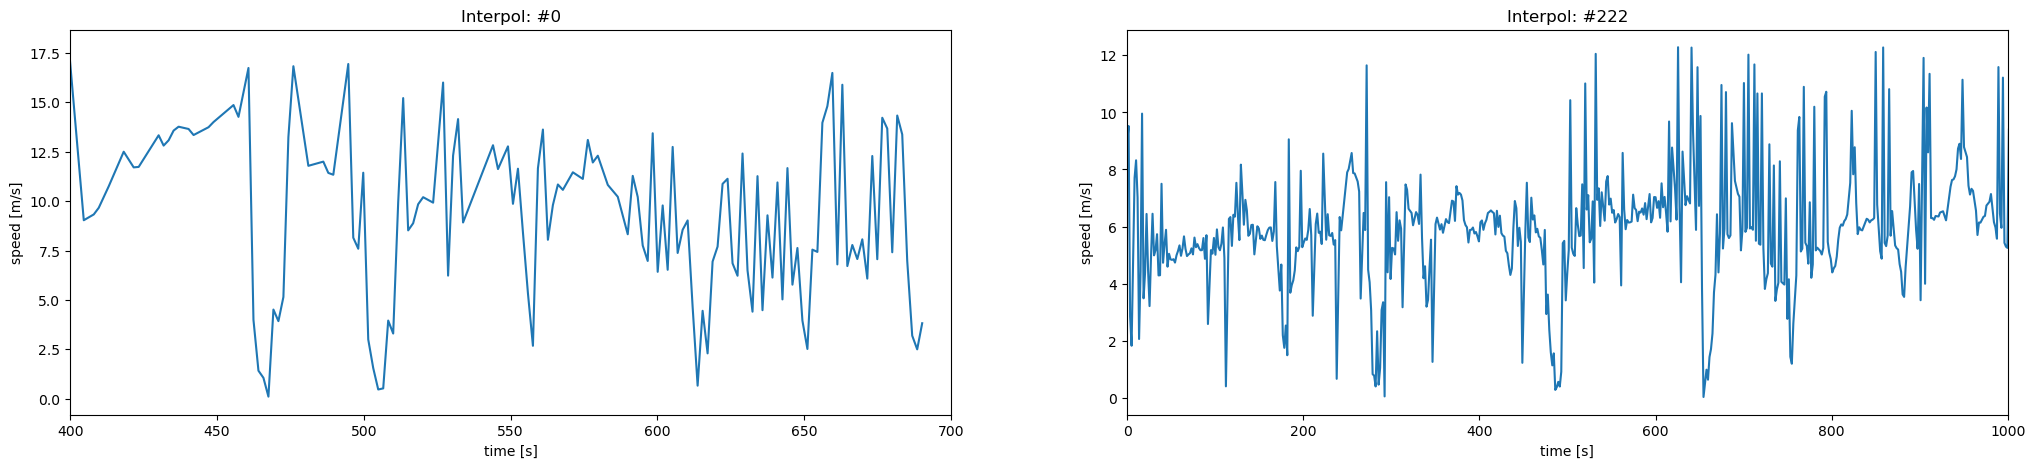

In [27]:
fig = plt.figure(figsize=(25, 5*rows))
plt.subplot(rows,2,1)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
#plt.plot(one["timesum"], one["vel"], "-")
plt.plot([1.7*x for x in range(len(one["vel"]))], one["vel"], "-")
plt.xlim([400, 700])
#plt.ylim([0, 140])
plt.title("Interpol: #"+str(trip1))

plt.subplot(rows,2,2)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
#plt.plot(two["timesum"], two["vel"], "*-")
plt.plot([1.7*x for x in range(len(two["vel"]))], two["vel"], "-")
plt.xlim([0, 1000])
#plt.ylim([0, 24])
plt.title("Interpol: #"+str(trip2))
plt.show()

## Smoothing applied

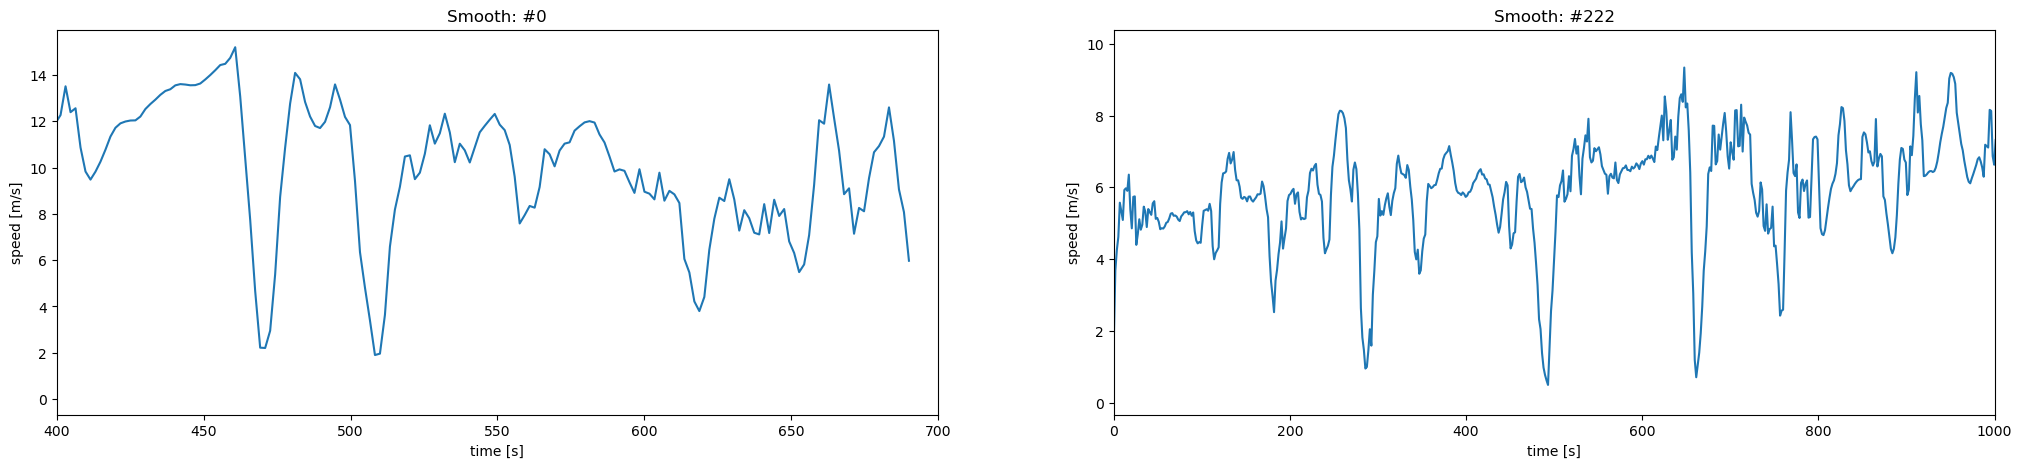

In [28]:

###
fig = plt.figure(figsize=(25, 5*rows))
plt.subplot(rows,2,1)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
#plt.plot(one["timesum"], one["vel"], "-")
plt.plot([1.7*x for x in range(len(one["vel_smooth"]))], one["vel_smooth"], "-")
plt.xlim([400, 700])
#plt.ylim([0, 140])
plt.title("Smooth: #"+str(trip1))

plt.subplot(rows,2,2)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
#plt.plot(two["timesum"], two["vel"], "*-")
plt.plot([1.7*x for x in range(len(two["vel_smooth"]))], two["vel_smooth"], "-")
plt.xlim([0, 1000])
#plt.ylim([0, 24])
plt.title("Smooth: #"+str(trip2))

plt.show()

## Zoomed in comparison

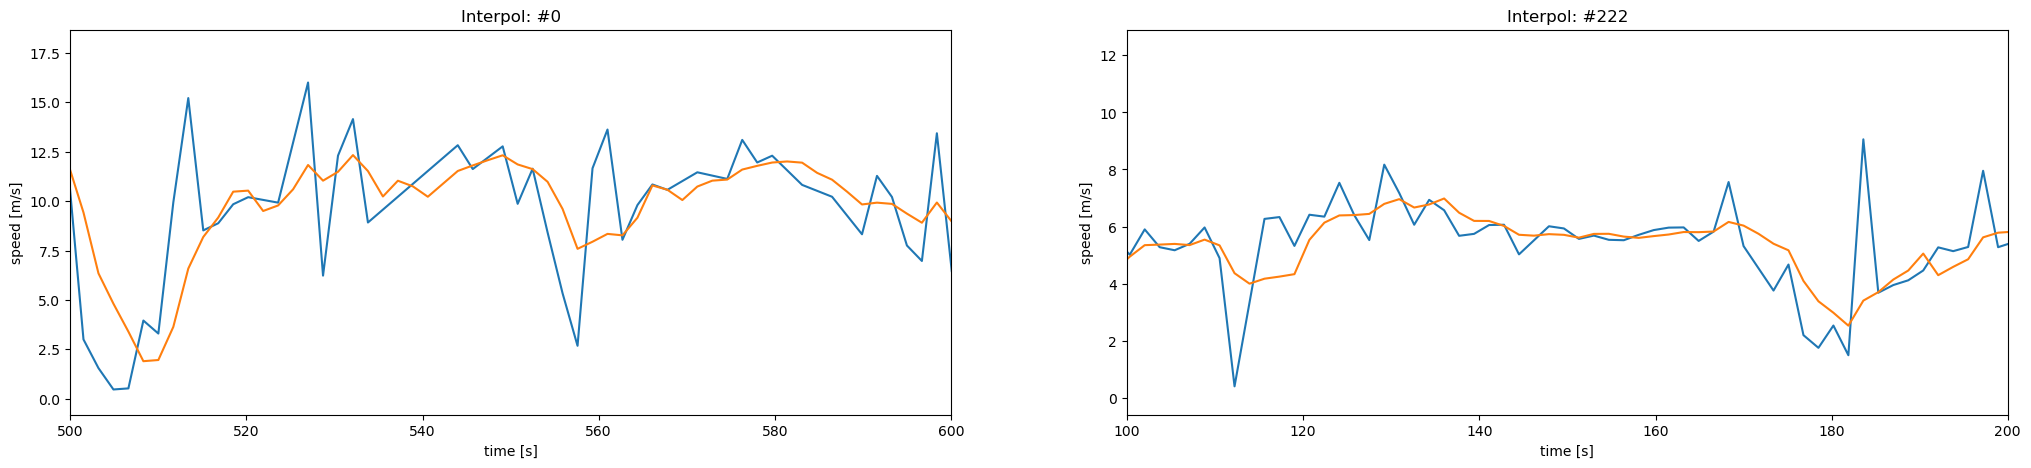

In [29]:
fig = plt.figure(figsize=(25, 5*rows))
plt.subplot(rows,2,1)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
#plt.plot(one["timesum"], one["vel"], "-")
plt.plot([1.7*x for x in range(len(one["vel"]))], one["vel"], "-")
plt.plot([1.7*x for x in range(len(one["vel_smooth"]))], one["vel_smooth"], "-")
plt.xlim([500, 600])
#plt.ylim([0, 140])
plt.title("Interpol: #"+str(trip1))

plt.subplot(rows,2,2)
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
#plt.plot(two["timesum"], two["vel"], "*-")
plt.plot([1.7*x for x in range(len(two["vel"]))], two["vel"], "-")
plt.plot([1.7*x for x in range(len(two["vel_smooth"]))], two["vel_smooth"], "-")
plt.xlim([100, 200])
#plt.ylim([0, 24])
plt.title("Interpol: #"+str(trip2))
plt.show()

# Different types of smoothing
Below you can try out other types of smoothing

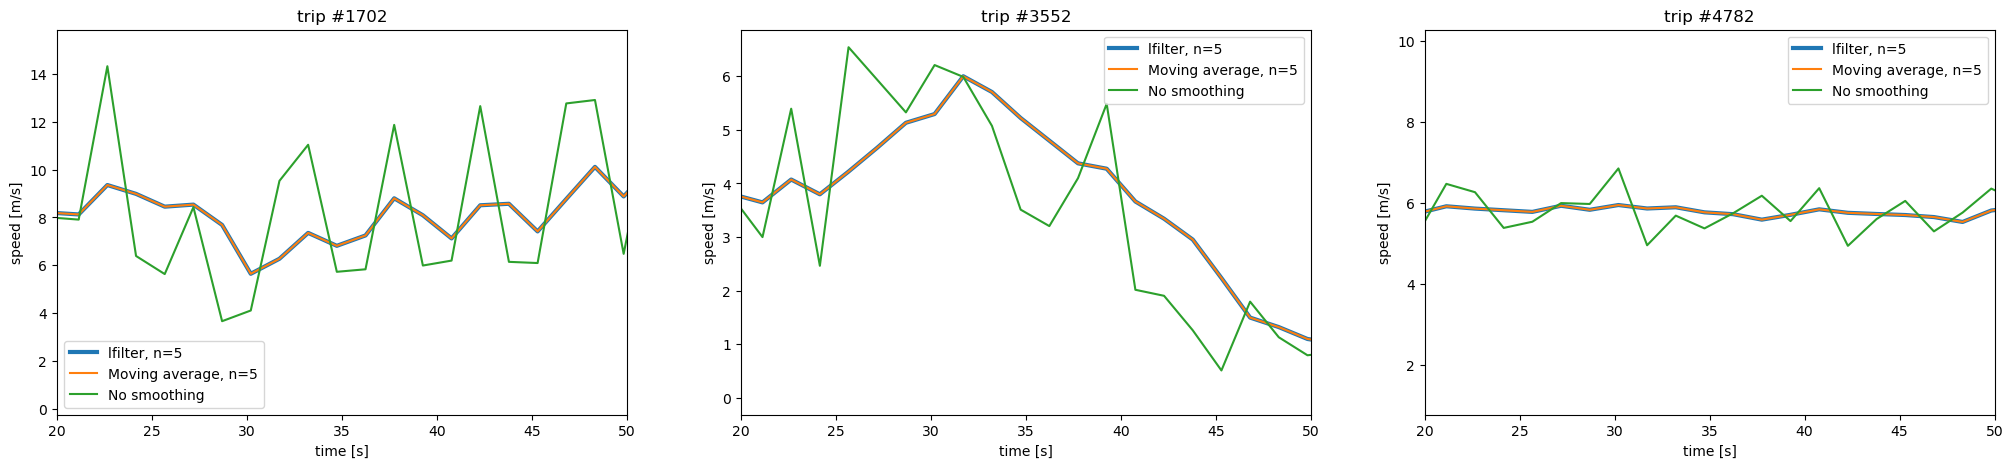

In [322]:
GM["vel_smooth_test"] = GM["vel"].rolling(5).mean() #change n 
#GM["vel_smooth_test"] = GM["vel"].ewm(span=3).mean()

N = 3 # to plot

trip_ids = GM.trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[GM["trip_id"] == trip]["time"].cumsum().tolist()
    vels = GM.loc[GM["trip_id"] == trip]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [s]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-", label="lfilter, n=5", linewidth=3)
    plt.plot(times, GM.loc[GM["trip_id"] == trip]["vel_smooth_test"], label="Moving average, n=5")
    plt.plot(times, GM.loc[GM["trip_id"] == trip]["vel"], label="No smoothing")
    #plt.plot(times, GM.loc[GM["trip_id"] == trip]["vel"])
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([20, 50])
    plt.title("trip #"+str(trip))
    plt.legend()
plt.show()

In [31]:
#Delete that column before moving on
#GM.drop("vel_smooth_test", axis=1, inplace=True) 

## How the distribution of velocities changes after smoothing

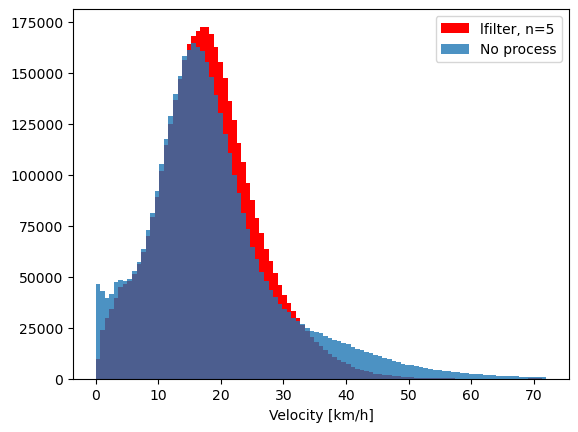

In [38]:
bins = np.linspace(0, 72, 100) 
GM["vel_smooth_km"] = GM["vel_smooth"]*3.6
GM["vel_og_km"] = GM["vel_og"]*3.6

plt.hist(GM["vel_smooth_km"], label='lfilter, n=5', bins=bins, alpha=1, color='red')
#plt.hist(GM["vel"], label='Interpolation', bins=bins, alpha=0.7, color='tab:blue')
plt.hist(GM["vel_og_km"], label='No process', bins=bins, alpha=0.8, color='tab:blue')
plt.xlabel("Velocity [km/h]")
plt.legend()
 
plt.show()

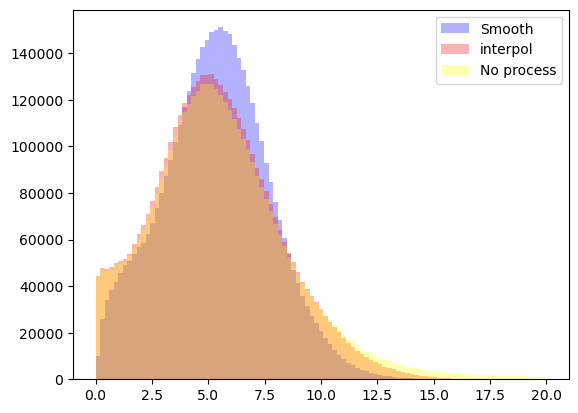

In [33]:
bins = np.linspace(0, 20, 100) 

plt.hist(GM_ind["vel_smooth"], label='Smooth', bins=bins, alpha=0.3, color='blue')
plt.hist(GM_ind["vel"], label='interpol', bins=bins, alpha=0.3, color='red')
plt.hist(GM_ind["vel_og"], label='No process', bins=bins, alpha=0.3, color='yellow')
plt.legend()
 
plt.show()

# How long are the trips?
Im cutting some stuff out for brevity (HAHA) but suffice to say that we have around 700 trips that are between 20-30 minutes long.

## End and start of trip

Not included here is the motivation for why the first and last datapoints are bad, and they will not be included in the final data. Additionally, all functions applied to a dataframe are sooo much faster if applied once to the dataframe, and not in chunks (trip-wise). 

It will also be good to know where in the trip a certain occurance takes place. So a column is created which is set to -1 if the row should not be included (first and last five data-points of each trip) and else set to where in the trip the reading takes place [0,1,2,3..,etc]

trips shorter than 50 readings are deleted

In [36]:
trip_ids = GM.trip_id.unique().tolist()

for trip_id in trip_ids:
    L = len(GM.loc[GM["trip_id"] == trip_id])
    if L < 50:
        GM.drop(GM.loc[GM["trip_id"] == trip_id].index.tolist(),inplace=True)
    else:
        pos = [x for x in range(L-10)]
        pos = [-1,-1,-1,-1,-1] + pos + [-1,-1,-1,-1,-1]
        GM.loc[GM["trip_id"] == trip_id, "count"] = pos

In [37]:
GM["total_time"] = np.nan

trip_ids = GM.trip_id.unique().tolist() #get trip indices

for trip_id in trip_ids:
    GM.loc[GM.loc[GM["trip_id"] == trip_id].index.tolist()[0], "total_time"] = GM.loc[GM.loc[GM["trip_id"] == trip_id].index.tolist()[-6]]["count"]

    
GM["total_time"].fillna(method="ffill", inplace=True) #assign the same length as first idx to all other points in trip

In [36]:
#The total time is in time-steps not in actual time so 1 minute = 60/1.51 time-steps

#These are the trips that are between 20 and 30 minutes long
shortest_trip = 20*60/1.51
longest_trip = 30*60/1.51

GM.loc[(GM["total_time"] >= shortest_trip) & (GM["total_time"] <= longest_trip)]
print("Number of trips that are between", shortest_trip, "and", longest_trip, "timesteps:",GM.loc[(GM["total_time"] >= shortest_trip) & (GM["total_time"] <= longest_trip)].trip_id.nunique())

Number of trips that are between 794.7019867549669 and 1192.0529801324503 timesteps: 752


Which is actually a bit annoying so lets scale final time to minutes,
and count to seconds

In [37]:
GM["total_time"] = GM["total_time"]*1.5/60

In [38]:
#GM["count"] = GM["count"]*1.51

## Slowing down?
We want to know if there is any correlation between when in the trip something happens and what happens, for example:
* Do we accelerate less?
* Do we keep lower velocities?

So that we still have enough data to work with I decided to look at trips of length 20-30 minutes. 

Each trip has a mean velocity
The velocity in one point will differ from the mean velocity with 

In [39]:
#We make a copy so that we do not need to subindex like crazy (we also exclude all start and end-points)
GM_span = GM.loc[(GM["total_time"] >= 25) & (GM["count"] >= 0 )].copy()

In [41]:
GM_span["time_sum"] = GM_span["count"]*1.50/60

In [42]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [-np.inf, 5,10, 15, 20,25, np.inf]

#name the bins (should be one less than bin_edges)
bin_labels = [5,10,15,20,25,30]

# This part does the grouping based on the input above
GM_span[grouped_variable_name] = pd.cut(
    GM_span[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10


In [43]:
trip_ids = GM_span.trip_id.unique().tolist() #get trip indexes
#GM_span["mean_vel"] = np.nan #create new empty column
                                                                 
comp = []

for trip_id in trip_ids:
    trip_comp = []
    overall_mean = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"] <= bin_labels[-2])]["vel_smooth"].mean()
    trip_comp.append(overall_mean)  
    for section in bin_labels[0:-1]:
        section_mean = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section)]["vel_smooth"].mean()
        trip_comp.append(section_mean)
        #GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section) , "mean_vel"] = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section)]["vel_smooth"].mean()
    comp.append(trip_comp)
    
    
per_comp = []
for trip_comp in comp:
    per_trip = []
    mean_trip = trip_comp[0]
    for elem in trip_comp[1::]:
        per_trip.append(elem/mean_trip)
        #per_trip.append(trip_comp[i] - mean_trip)
    per_comp.append(per_trip)

    
to_plot = []
for i in range(len(per_comp[0])):
    s = 0
    for per in per_comp:
        s+=per[i]
    to_plot.append(s)

k= sum(to_plot)
for i in range(len(per_comp[0])):
    to_plot[i] = to_plot[i]/k
    
print(to_plot)


KeyboardInterrupt



As we can see, velocity does not go down with time (at least not during the first 25 minutes)

plt.bar([x - 2.5 for x in bin_labels[0:-1]], to_plot, width=5)
plt.title("Change in mean velocity over time")
plt.xlabel("time")
plt.ylabel("mean velocity")
plt.show()

# Acceleration

We calculate the acceleration for both velocities (vel and vel_smooth - NOT OG_vel)


The method by which we find v_diff uses pandas.rolling, 
This will assign the difference between the velocities at row i and row i+1 to row i, i.e., 


v_diff[i] = -(vel[i] - vel[i+1])



this means that if we do this separately to each trip, the last idx will be assigned v_diff = NaN (since v[final_idx + 1] does not exist), i.e.,
v_diff[final_idx] = NaN



But it's much faster to loop through all at once, so we need to set all v_diff[final_idx] = NaN, *after* the fact.


since this will give a value for the difference between the last vel in trip j and the first vel in trip j+1 we also set this acc-value to NaN after the fact, so that we don't accidentally use it.



Specifically I have chosen to assign acceleration as:
* acc[i] = vel[i+1] - vel[i]

In [45]:
v_use = "vel_og"
acc_name = "acc_og"

GM[acc_name] = -GM[v_use].diff(periods=-1)

#GM[acc_name] = GM.loc[:, (v_use)][::-1].rolling(window=2).apply(lambda GM: -(GM.iloc[1] - GM.iloc[0]))[::-1]
GM[acc_name] = GM.loc[:, (acc_name)]/GM.loc[:, ("time")]


GM.loc[GM["count"] < 0, acc_name] = np.nan

In [46]:
GM.head(6)

trip_id                                           geometry  \
idd                                                               
0          0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...   
1          0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...   
2          0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...   
3          0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...   
4          0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...   
5          0  LINESTRING (-73.577 45.507, -73.578 45.507, -7...   

                    stop  id_origine                start       length  \
idd                                                                      
0    2013-06-25 16:34:16          52  2013-06-25 16:21:21  3317.788025   
1    2013-06-25 16:34:16          52  2013-06-25 16:21:21     4.164946   
2    2013-06-25 16:34:16          52  2013-06-25 16:21:21    12.379816   
3    2013-06-25 16:34:16          52  2013-06-25 16:21:21    19.563040   
4    2013-06-25 16:34:16          52  2013-06-25 16:21:21    25.352687   
5    2013-06-25 16:34:16          52  2013-06-25 16:21:21    22.608693   

     purpose                               liste_segments_jsonb  n_coord  id  \
idd                                                                            
0    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
1    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
2    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
3    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
4    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   
5    Commute  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511  52   

     ... time       vel_og     Z_val_20        vel  vel_smooth  vel_smooth_km  \
idd  ...                                                                        
0    ...  1.5  2211.858683  1000.000000        NaN         NaN            NaN   
1    ...  1.5     2.776631    -0.986791   2.776631         NaN            NaN   
2    ...  1.5     8.253211     0.092033   8.253211         NaN            NaN   
3    ...  1.5    13.042027     1.035374  13.042027         NaN            NaN   
4    ...  1.5    16.901791     1.795704  16.901791         NaN            NaN   
5    ...  1.5    15.072462     1.435347  15.072462   11.209224      40.353208   

       vel_og_km  count  total_time    acc_og  
idd                                            
0    7962.691259   -1.0       397.0       NaN  
1       9.995871   -1.0       397.0       NaN  
2      29.711559   -1.0       397.0       NaN  
3      46.951296   -1.0       397.0       NaN  
4      60.846449   -1.0       397.0       NaN  
5      54.260864    0.0       397.0 -0.109856  

[6 rows x 25 columns]

In [47]:
v_use = "vel_smooth"
acc_name = "acc_smooth"

GM[acc_name] = -GM[v_use].diff(periods=-1)
GM[acc_name] = GM.loc[:, (acc_name)]/GM.loc[:, ("time")]

GM.loc[GM["count"] < 0, acc_name] = np.nan

In [56]:
v_use = "vel_smooth_test"
acc_name = "acc_smooth_test"

GM[acc_name] = -GM[v_use].diff(periods=-1)
GM[acc_name] = GM.loc[:, (acc_name)]/GM.loc[:, ("time")]

GM.loc[GM["count"] < 0, acc_name] = np.nan

In [75]:
v_use = "vel"
acc_name = "acc"

GM[acc_name] = -GM[v_use].diff(periods=-1)
GM[acc_name] = GM.loc[:, (acc_name)]/GM.loc[:, ("time")]

GM.loc[GM["count"] < 0, acc_name] = np.nan

We plot how the distribution of acceleration changes after smoothing

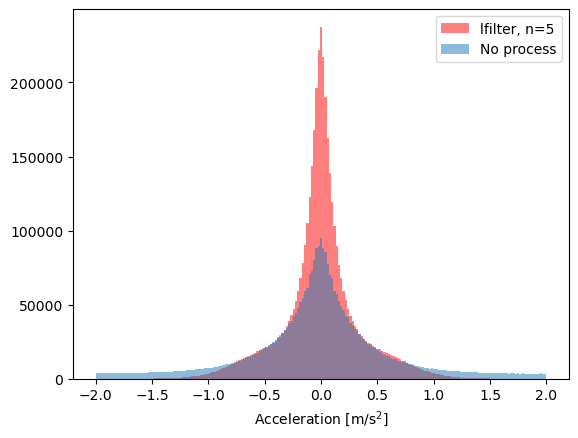

In [50]:
bins = np.linspace(-2, 2, 200) #Create bins of equal size between min_value and max_value

#plt.hist(GM["acc"], label="Interpolation", bins=bins, alpha = 0.5, color="red")
plt.hist(GM["acc_smooth"],label="lfilter, n=5", bins=bins, alpha=0.5, color="red")
plt.hist(GM["acc_og"], label="No process", bins=bins, alpha = 0.5, color="tab:blue") #not super interesting, very similar to interpol
#plt.hist(GM["acc_smooth_test"],label="EMA, n=3", bins=bins, alpha=0.5, color="green")
plt.xlabel("Acceleration [m/s$^2$]")
plt.legend()
 
plt.show()

# Generating an acceleration function
We start by copying over all points where we accelerate to a new dataframe (also skip end and start points)

In [51]:
GM_a = GM.loc[(GM["acc_smooth"] >= 0) & (GM["count"] >= 0)][["vel_smooth", "acc_smooth"]].copy()

We start with binning the velocity in relevant bin-sizes. I have used size 0.1 (m/s) since this is what we use in the model.

The max bin i get from:

In [52]:
print(GM_a["vel_smooth"].nlargest(1))
print(GM_a["acc_smooth"].nlargest(1))

idd
3111561    19.872271
Name: vel_smooth, dtype: float64
idd
1433727    2.56293
Name: acc_smooth, dtype: float64


In [53]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_a[grouped_variable_name] = pd.cut(
    GM_a[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#GM_a.fillna(1, inplace=True) #if the vel/accel is denoted as -0 these will not we assigned a bin, so we assign them to 1.
#actually switched the left lim to -inf so not an issue anymore

In [54]:
#Here we simply set the bin-sizes for the average acc
variable = "acc_smooth"  
grouped_variable_name = "acc_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,26):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,26):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_a[grouped_variable_name] = pd.cut(
    GM_a[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

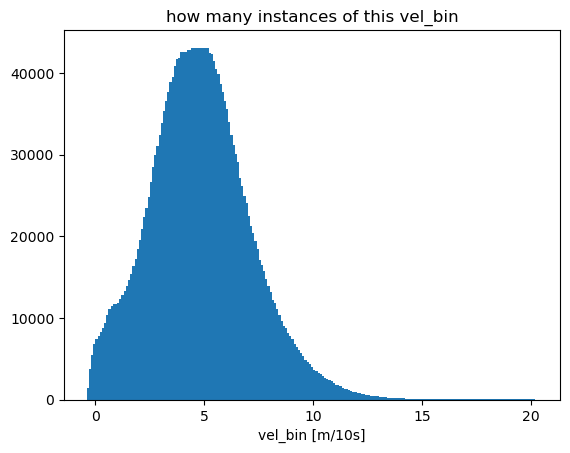

In [55]:
variables = ["vel_bin"] 

GM_count = (
    GM_a
    .groupby(variables)
    .agg("count")
    .reset_index()
)  # Aggregation to tariff cells

plt.xlabel(str(variables[0])+ " [m/10s]")
plt.bar([x/10 for x in GM_count.index.tolist()], GM_count["vel_smooth"])
plt.title("how many instances of this "+ str(variables[0]))
plt.show()

# Reminder -
set GM_a.loc[GM_a["acc_bin"] <= 1]
and find the "slow rolling stops"

In [56]:
variables = ["vel_bin"] 

GM_agg = (
    GM_a.loc[GM_a["acc_bin"] <= 1]
    .groupby(variables)
    .agg("count")
    .reset_index()
)  # Aggregation to tariff cells

plt.xlabel(str(variables[0])+ " [m/10s]")
plt.bar([x/10 for x in GM_count.index.tolist()], GM_count["vel_smooth"])
plt.bar([x/10 for x in GM_agg.index.tolist()], GM_agg["vel_smooth"])
plt.title("how many instances of this "+ str(variables[0]))
plt.show()

We do the same for the un-processed velocities

In [76]:
GM_OGa = GM.loc[(GM["acc"] >= 0) & (GM["count"] >= 0)][["vel", "acc"]].copy()

#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_OGa[grouped_variable_name] = pd.cut(
    GM_OGa[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [60]:
GM_testa = GM.loc[(GM["acc_smooth"] >= 0) & (GM["count"] >= 0)][["vel_smooth", "acc_smooth"]].copy()

#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_smooth_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_testa[grouped_variable_name] = pd.cut(
    GM_testa[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

For all velocities in a bin, we plot the mean acceleration, the max acceleration and the mean of the top ten accelerations.

In [100]:
#mean_acc = GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"])
#max_acc = GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1)
#meanmax_acc = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())


We also want to be able to compare it to the current acceleration function

In [61]:
### Input

m_bike = 18.3 #[kg] mass of bike
m_human = 73.5 #mass of cyclist
mass = m_human+m_bike
level = "fit"

### Parameters
E_output = {"untrained": 1.5, "fit": 3.0, "highP": 5.0} #[W/kg]
P_max = m_human*E_output[level] #[W]

g = 9.81 # [m/s²]
RRcoef = 0.008 # [1]  % Rolling Resistance coefficient #####Changed!!! OK!
cw = 1 # [1]  
A = 0.5 # [m^2] % frontal area bike and cyclist
s = 0 #[rad] degree of slope
 
# Air density 
temp = 20 # [degree]
Temp = 273.15 + temp
rho = (10**(-5))*(Temp**2) - 0.0048*Temp + 1.2926 #which to use?

In [62]:
def acc_fun(v):
    #takes v=velocity as an argument
    #returns acceleration as a function of v
    if v == 0: #to avoid dividing with zero
        acc = 2
    else: 
        P_roll_steady = mass * g * RRcoef * v
        P_air_steady = 0.5 * cw * A * rho * (v**3)
        P_climb_steady = (mass)*g*s
        P_lost = P_roll_steady + P_air_steady + P_climb_steady

        P_acc = P_max - P_lost
        acc = P_acc/(mass*v)
    acc = min(2, acc) #max 2m/s
    acc = max(acc,0) #not negative
    return acc


vel_list = [x/10 for x in range(1,201)]
acc_list = []

for v in vel_list:
    acc_list.append(acc_fun(v))

## Plot and compare potential acceleration function 
* Smoothed data
* OG data
* acceleration function as provided by *physics* ;)

In [65]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc_og"].agg(["mean"]), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].agg(["mean"]), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")

plt.legend()
plt.plot()
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc_og"].nlargest(1), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_smooth_bin")["acc_smooth"].nlargest(1), "*", label="EMA n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.title("Max acceleration")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc_og"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="lfilter, n=5")

plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.title("Mean acceleration, from 10 highest accelerations")


plt.show()

ValueError: x and y must have same first dimension, but have shapes (200,) and (199,)

In [143]:
#GM_testa.rename(columns = {"acc_smooth_test": "acc"}, inplace = True)
#GM_a.rename(columns = {"acc_smooth": "acc"}, inplace = True)


vel_bin
1      9.341640
2      9.152831
3      9.007803
4      8.974601
5      8.518482
         ...   
196    0.151782
197    0.131524
198         NaN
199         NaN
200         NaN
Name: acc, Length: 200, dtype: float64

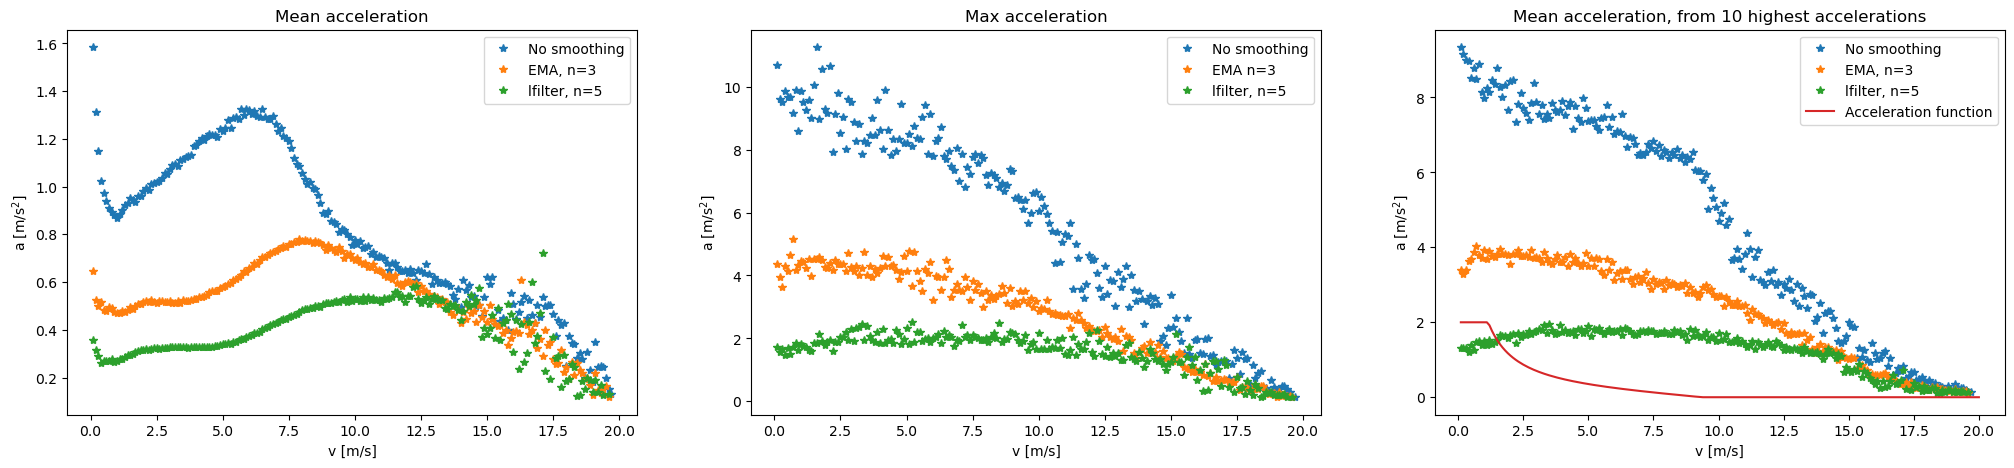

In [144]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in range(1,201)], GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].agg(["mean"]), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].agg(["mean"]), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")

plt.legend()
plt.plot()
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].nlargest(1).reset_index(level=[0,1])["vel_bin"].tolist()], GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].nlargest(1), "*", label="No smoothing")
plt.plot([x/10 for x in GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].nlargest(1).reset_index(level=[0,1])["vel_bin"].tolist()], GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].nlargest(1), "*", label="EMA n=3")
plt.plot([x/10 for x in GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].nlargest(1).reset_index(level=[0,1])["vel_bin"].tolist()], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.title("Max acceleration")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.plot([x/10 for x in GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()).index.tolist()], GM_OGa.loc[GM_OGa["acc"] >= 0.1].groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="No smoothing")
plt.plot([x/10 for x in GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()).index.tolist()], GM_testa.loc[GM_testa["acc_smooth_test"] >= 0.1].groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()), "*", label="EMA, n=3")
plt.plot([x/10 for x in GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()).index.tolist()], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="lfilter, n=5")

plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.title("Mean acceleration, from 10 highest accelerations")


plt.show()

## Plot only smoothed 

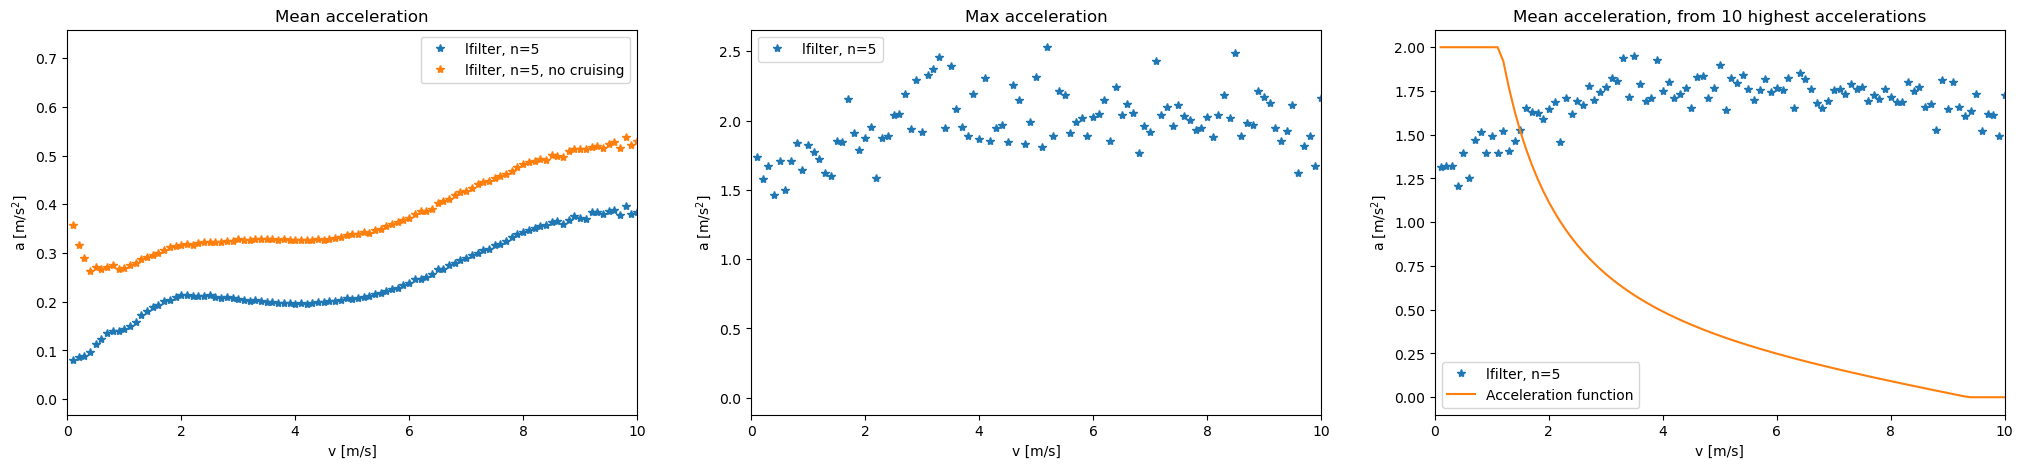

In [146]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].agg(["mean"]), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_smooth"] >= 0.1].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="lfilter, n=5, no cruising")


plt.legend()
plt.plot()
plt.xlim([0,10])
plt.title("Mean acceleration")

plt.subplot(1,3,2)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].nlargest(1), "*", label="EMA n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="lfilter, n=5")
plt.legend()
plt.xlim([0,10])
plt.title("Max acceleration")

plt.subplot(1,3,3)
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="No smoothing")
#plt.plot([x/10 for x in range(1,201)], GM_testa.groupby("vel_bin")["acc_smooth_test"].apply(lambda x: x.nlargest(10).mean()), "*", label="EMA, n=3")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()), "*", label="lfilter, n=5")

plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.legend()
plt.xlim([0,10])
plt.title("Mean acceleration, from 10 highest accelerations")



plt.show()

We can attempt to polyfit a function to the mean-max acceleration

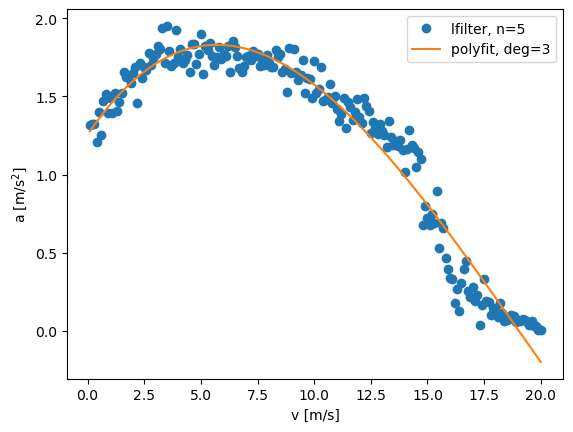

In [147]:
x = [x/10 for x in range(1,201)]

y = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean())

coef = np.polyfit(x,y,3)
poly2d_fn = np.poly1d(coef) 
 
plt.plot(x, y, "o", label="lfilter, n=5")
plt.plot(x, poly2d_fn(x), label="polyfit, deg=3")
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.legend()
#plt.xlim(0, 20)
#plt.ylim(-2, 0)
plt.show()

Or to the mean acceleration

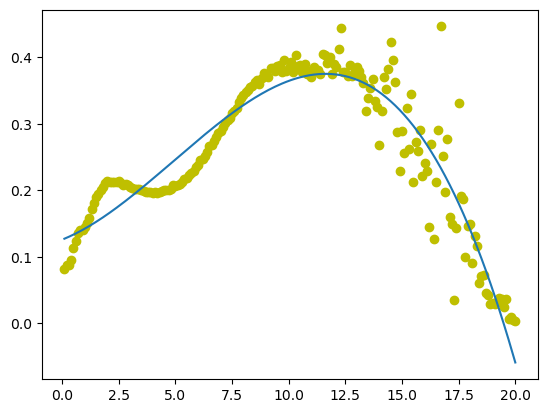

In [148]:
x = [x/10 for x in range(1,201)]

#y = GM_d.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nsmallest(10).mean())
y = GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"])["mean"]

coef = np.polyfit(x,y,3)
poly2d_fn = np.poly1d(coef) 
 
plt.plot(x,y, 'yo', x, poly2d_fn(x))
#plt.xlim(0, 20)
#plt.ylim(-2, 0)
plt.show()

In [68]:
#we can look at the distribution of the acceleration for one specific velocity
vel = 100

GM_a.loc[GM_a["vel_bin"]==vel].groupby("acc_bin")["vel_smooth"].agg(["count"]).plot.bar();


It might be interesting to be able to compare individual trips so we do the same but try to aggregate wrt trip_id as well. It might not work, but let's try...

Since there is so little data (comparatively) for one trip we bin the velocities in 1m/s-bins (as opposed to 0.1 m/s as above).

In [71]:
GM_ind = GM.loc[(GM["acc_smooth"] >= 0) & (GM["count"] >=0)][["trip_id", "vel_smooth", "acc_smooth"]].copy()

In [72]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,21):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,21):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_ind[grouped_variable_name] = pd.cut(
    GM_ind[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [73]:
GM_ind.head(3)

trip_id  vel_smooth  acc_smooth vel_bin
11        0    5.683668    0.005125       6
12        0    5.691407    0.357779       6
13        0    6.231653    0.138131       7

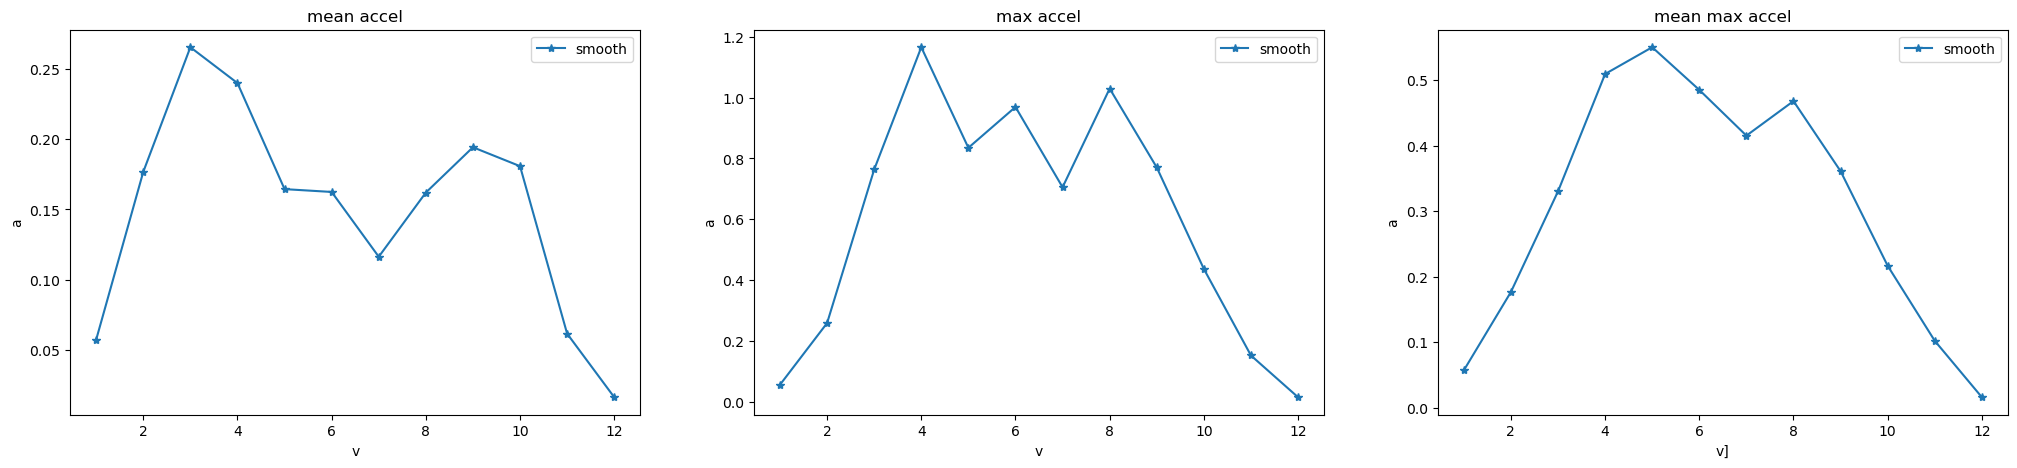

In [74]:
fig = plt.figure(figsize=(25, 5))
    
#mean_acc = GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"])
#max_acc = GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1)
#meanmax_acc = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())

trip_id = 4

plt.subplot(1,3,1)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/1 for x in range(1,21)], GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "-*", label="smooth")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="OG")
plt.legend()
plt.plot()
plt.title("mean accel")

plt.subplot(1,3,2)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/1 for x in GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].nlargest(1).reset_index(1).index.tolist()], GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].nlargest(1).reset_index(1)["acc_smooth"], "-*", label="smooth")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="OG")
plt.legend()
plt.title("max accel")

plt.subplot(1,3,3)
plt.xlabel("v]")
plt.ylabel("a")
plt.plot([x/1 for x in GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()).index.tolist()], GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()), "-*", label="smooth")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="OG")
#plt.plot(vel_list, acc_list, "*", label="function")
plt.legend()
plt.title("mean max accel")



plt.show()

In [75]:
N = 9

min_vals = 5
n = 2

trip_ids = GM.trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))


X = [x/10 for x in range(1,201)]
Y = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())

coef = np.polyfit(x,y,2)
poly_OG = np.poly1d(coef) 




for i in range(N):
    trip_id = trip_ids[trips[i]]
    x = [x/1 for x in GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(n).mean()).loc[GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].agg("count").values >= min_vals].index.tolist()]
    y = GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(n).mean()).loc[GM_ind.loc[GM_ind["trip_id"]== trip_id].groupby("vel_bin")["acc_smooth"].agg("count").values >= min_vals]
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("v [m/s]")
    plt.ylabel("a [m/s^2]")
    coef = np.polyfit(x,y,2)
    poly2d_fn = np.poly1d(coef) 

    plt.plot(x,y, 'yo', x, poly2d_fn(x))
    #plt.plot(X, poly_OG(X))
    #plt.xlim([min(x)-1, max(x)+1])
    #plt.ylim([min(y), max(y)])
    plt.title("trip #"+str(trip))

plt.show()


/Users/johannaskantorp/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


## Deceleration

We do the same for deceleration

In [149]:
GM_d = GM.loc[(GM["acc_smooth"] <= 0) & (GM["count"]>=0)][["vel_smooth", "acc_smooth"]].copy()
print(GM_d["vel_smooth"].nlargest(1))
print(GM_d["acc_smooth"].nsmallest(1))

3109431    19.908977
Name: vel_smooth, dtype: float64
3109673   -2.435303
Name: acc_smooth, dtype: float64


In [150]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = []
for i in range(201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_d[grouped_variable_name] = pd.cut(
    GM_d[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#Here we simply set the bin-sizes for the average speed
variable = "acc_smooth"  
grouped_variable_name = "dec_bin"

#set the edges of the bins
bin_edges = []
k=24
for i in range(25):
    j=k-i
    bin_edges.append(-j/10)

#name the bins (should be one less than bin_edges)
bin_labels = []
k=24
for i in range(1,25):
    j=k-i
    bin_labels.append(-j)

# This part does the grouping based on the input above
GM_d[grouped_variable_name] = pd.cut(
    GM_d[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [151]:
GM_OGd = GM.loc[(GM["acc"] <= 0) & (GM["count"]>=0)][["vel", "acc"]].copy()
print(GM_OGd["vel"].nlargest(1))
print(GM_OGd["acc"].nsmallest(1))

1431624    19.992147
Name: vel, dtype: float64
1808846   -11.335565
Name: acc, dtype: float64


In [152]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = []
for i in range(201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_OGd[grouped_variable_name] = pd.cut(
    GM_OGd[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not


In [153]:
#mean_dec = GM_d.groupby("vel_bin")["acc_smooth"].agg(["mean"])
#max_dec = GM_d.groupby("vel_bin")["acc_smooth"].nsmallest(1)
#meanmax_dec = GM_d.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nsmallest(10).mean())

vel_smooth  acc_smooth vel_bin dec_bin
5         13.545133   -0.108358     136      -1
6         13.381513   -0.948174     134      -9
7         11.949770   -1.677887     120     -16
8          9.416160   -1.244694      95     -12
9          7.536673   -0.918919      76      -9
...             ...         ...     ...     ...
4327020    5.727574   -0.229463      58      -2
4327021    5.381085   -0.311701      54      -3
4327022    4.910416   -0.205625      50      -2
4327024    4.715514   -0.100953      48      -1
4327025    4.563075   -0.152705      46      -1

[2154624 rows x 4 columns]

In [180]:
fig = plt.figure(figsize=(25, 10))

plt.subplot(2,3,1)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="decel")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="accel")
plt.legend()
plt.title("mean decel")

plt.subplot(2,3,2)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.groupby("vel_bin")["acc_smooth"].nsmallest(1), "*")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].nlargest(1), "*", label="smooth")

plt.title("max decel")

plt.subplot(2,3,3)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nsmallest(10).nlargest(10).mean()), "*")
plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="smooth")
plt.title("mean max decel")

plt.subplot(2,3,4)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="decel, no cruise")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_bin"] >= 2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="accel, no cruise")
plt.legend()
plt.title("mean decel")

plt.subplot(2,3,5)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], [0.23 for x in range(1,201)])
plt.plot([x/10 for x in range(1,201)], GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="decel, no cruise")
plt.plot([x/10 for x in range(1,201)], GM_a.loc[GM_a["acc_bin"] >= 2].groupby("vel_bin")["acc_smooth"].agg(["mean"]), "*", label="accel, no cruise")

y = GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]).dropna()["mean"].tolist()[0:97]
x = [k/10 for k in GM_d.loc[GM_d["dec_bin"] <= -2].groupby("vel_bin")["acc_smooth"].agg(["mean"]).dropna()["mean"].index.tolist()][0:97]

coef = np.polyfit(x,y,1)
poly2d_fn = np.poly1d(coef) 

plt.plot(x, poly2d_fn(x))

plt.legend()
plt.xlim([0,10])
plt.title("mean decel")


plt.show()

[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0]


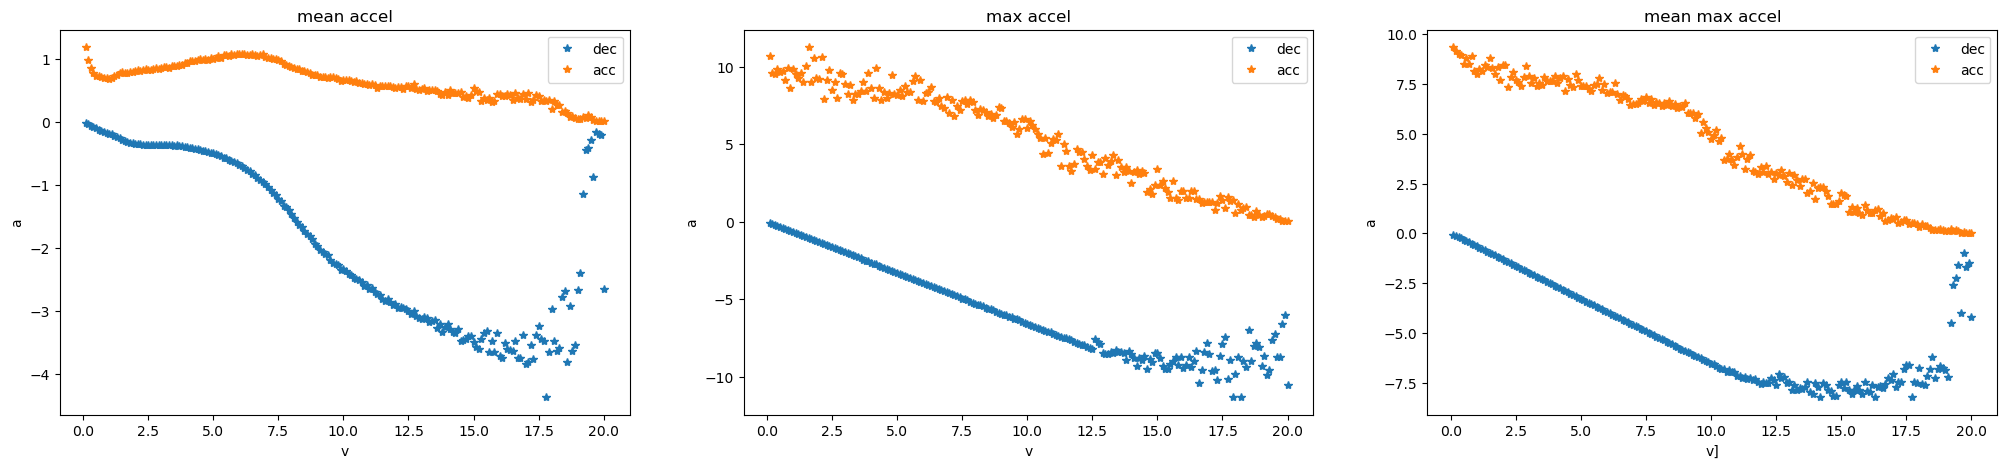

In [92]:
fig = plt.figure(figsize=(25, 5))
    
plt.subplot(1,3,1)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_OGd.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="dec")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].agg(["mean"]), "*", label="acc")
plt.legend()
plt.plot()
plt.title("mean accel")

plt.subplot(1,3,2)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_OGd.groupby("vel_bin")["acc"].nsmallest(1), "*", label="dec")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].nlargest(1), "*", label="acc")
plt.legend()
plt.title("max accel")

plt.subplot(1,3,3)
plt.xlabel("v")
plt.ylabel("a")
plt.plot([x/10 for x in range(1,201)], GM_OGd.groupby("vel_bin")["acc"].apply(lambda x: x.nsmallest(10).mean()), "*", label="dec")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).mean()), "*", label="acc")
#plt.plot(vel_list, acc_list, "-", label="function")
plt.legend()
plt.title("mean max accel")


plt.show()

In [174]:
GM_OG = GM.loc[(GM["acc"] >= 0) & (GM["count"] >= 0)][["vel", "acc"]].copy()

#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,21):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,21):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM_OG[grouped_variable_name] = pd.cut(
    GM_OG[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [198]:
variables = ["vel_bin"] 

GM_count = (
    GM_OG
    .groupby(variables)
    .agg("count")
    .reset_index()
)  # Aggregation to tariff cells

#plt.xlabel(str(variables[0])+ " [m/10s]")
#plt.bar([x/10 for x in GM_count.index.tolist()], GM_count["vel_smooth"])
#plt.title("how many instances of this "+ str(variables[0]))
#plt.show()
#GM_count

[-0.0463567  1.233941 ]


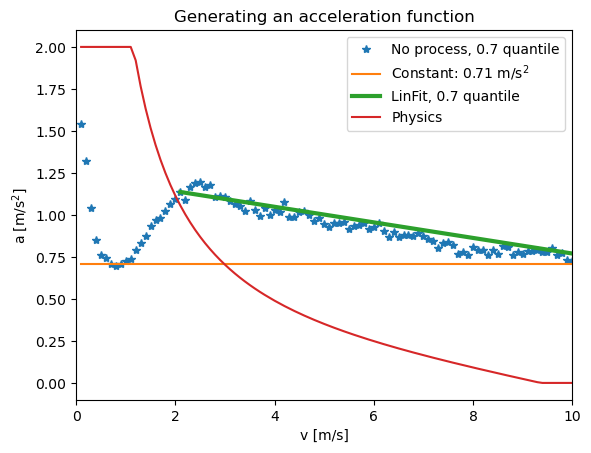

In [79]:

plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
#plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.nlargest(10).nsmallest(10).mean()), "*", label="No smoothing")
plt.plot([x/10 for x in range(1,201)], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)), "*", label="No process, 0.7 quantile")
#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean()), "*", label="smooth, max-mean")

#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.mean()), "*", label="smooth, mean")

#plt.plot([x/10 for x in range(1,201)], GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.quantile(0.9)), "*", label="smooth, 0.9 quantile")
plt.plot([x/10 for x in range(1,201)], [0.71 for y in range(1,201)], label="Constant: 0.71 m/s$^2$")


x = [x/10 for x in range(1,201)][0:25]


y1 = GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[0:25]
coef1 = np.polyfit(x,y1,3)
poly2d_1 = np.poly1d(coef1) 


x2 = [[x/10 for x in range(1,201)][20], [x/10 for x in range(1,201)][100]]
y2 = [GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[20], GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[100]]
coef2 = np.polyfit(x2,y2,1)
poly2d_2 = np.poly1d(coef2)

x2 = [x/10 for x in range(1,201)][20:101]
y2 = GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[20:101]
poly2d_2 = np.poly1d(coef2)
print(coef2)

#plt.plot(x, poly2d_1(x), "-", linewidth=3,label="fun, 0.7 quantile")
plt.plot(x2, poly2d_2(x2), "-", linewidth=3,label="LinFit, 0.7 quantile")



plt.plot(vel_list, acc_list, "-", label="Physics")
plt.xlim([0,10])
#plt.ylim([0,2])
plt.legend()
plt.title("Generating an acceleration function")


plt.show()

In [841]:
GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7)).tolist()[23]

1.1670243755903944

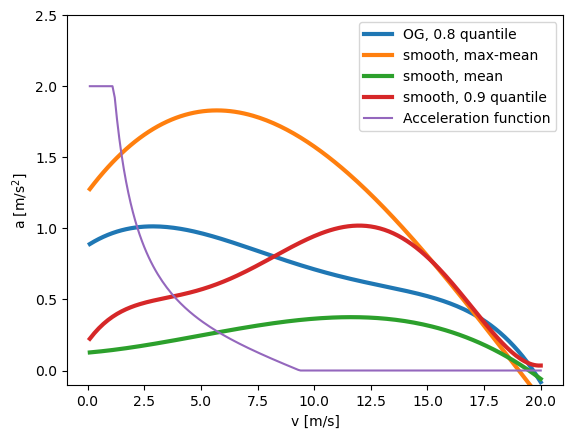

In [821]:
x = [x/10 for x in range(1,201)]

y = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).nsmallest(10).mean())

y1 = GM_OGa.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(0.7))
y2 = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.nlargest(10).mean())
y3 = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.mean())
y4 = GM_a.groupby("vel_bin")["acc_smooth"].apply(lambda x: x.quantile(0.9))


coef1 = np.polyfit(x,y1,5)
coef2 = np.polyfit(x,y2,3)
coef3 = np.polyfit(x,y3,3)
coef4 = np.polyfit(x,y4,5)

poly2d_1 = np.poly1d(coef1) 
poly2d_2 = np.poly1d(coef2) 
poly2d_3 = np.poly1d(coef3) 
poly2d_4 = np.poly1d(coef4) 
 
plt.plot(x, poly2d_1(x), "-", linewidth=3,label="OG, 0.8 quantile")
plt.plot(x, poly2d_2(x), "-", linewidth=3,label="smooth, max-mean")
plt.plot(x, poly2d_3(x), "-", linewidth=3,label="smooth, mean")
plt.plot(x, poly2d_4(x), "-", linewidth=3,label="smooth, 0.9 quantile")
plt.plot(vel_list, acc_list, "-", label="Acceleration function")
plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
plt.legend()
#plt.xlim(0, 20)
plt.ylim(-0.1, 2.5)
plt.show()

In [512]:
print("coef=", coef2)
print("poly2d = np.poly1d(coef)")
print("acc = poly2d(v)")



coef= [ 3.85308393e-04 -2.20331637e-02  2.13837555e-01  1.25533665e+00]
poly2d = np.poly1d(coef)
acc = poly2d(v)


## Conclusion

It honestly bothers me that the smoothed acceleration/deceleration are to some degree mirror images of each other. It's clear that this can't really happen with the unsmoothed since deceleration is just mostly the line y = -x. 
But still, it vexes me *smokes pipe for old-timey reasons*

I do think the smoothing is OK, but would loove the OG time-stamps. Just get me their entire processing-process and we could call it a day. I forgot my ADHD-medicine today so ..

In [112]:
[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,y,u,v,w,x,y,z] = [".","--","%","+","==","€","/¯","\_","##","_|","<<", "||_", "^", "/|", "0", ")", "Q","(ツ","¯","?",")_", "V", "/\*", "Y","&","r"]

print(s+h+r+u+g)

¯\_(ツ)_/¯


I mean, this happens because we cannot tell the smooting function that drastic drops are more realistic than drastic increases (the mirror images, not my procrastination). 



The smoothing function (rolling mean with n=5) works well *because* we get very similar results as 
Parkin et. al. 

In [338]:
print("  We have mean velocity:", round(GM.loc[GM["count"]>=0]["vel_smooth"].mean(),2), " and mean acceleration:", round(GM.loc[(GM["count"]>=0)&(GM["acc_smooth"]>=0)]["acc_smooth"].mean(),3))

print("They have mean velocity: 5.98 and mean acceleration: 0.247" )

  We have mean velocity: 5.0  and mean acceleration: 0.231
They have mean velocity: 5.98 and mean acceleration: 0.247


Their "proposition for acceleration" is that acceleration is (practically) constant until final speed is reached, Then cruising speed is kept until forced to break. 

## Randomly plot N trips

In [343]:
N = 9

trip_ids = GM.trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

In [353]:
trip = 720
times = [x*60 for x in GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()]
vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
plt.xlim([0, 500])
plt.title("trip #"+str(trip))

plt.show()

<AxesSubplot:>

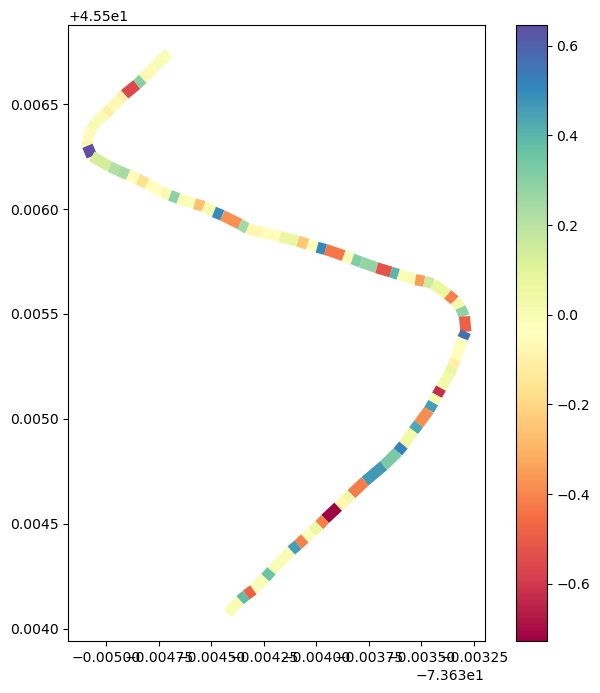

In [380]:
trip = 720

#GM.loc[(GM["trip_id"] == trip) &(GM["time_sum"]<= 10) & (GM["count"]>=0)].plot(column="vel_smooth", alpha=1, cmap="plasma", linewidth=8, figsize=(8, 8), legend=True)

GM.loc[(GM["trip_id"] == trip) & (GM["time_sum"]<= 2) & (GM["count"]>=0)].plot(column="acc_smooth", alpha=1, cmap="Spectral", linewidth=8, figsize=(8, 8), legend=True)


In [ ]:
sns.relplot(data=GM.loc[GM["trip_id"] == 720], x='Weight (kg)', y='Height (cm)', hue='Gender', hue_order=_genders, aspect=1.61)
plt.show()

In [359]:
import seaborn as sns

vel_bin
1      0.081262
2      0.087128
3      0.087635
4      0.095736
5      0.113579
         ...   
196    0.035999
197    0.006436
198    0.008745
199    0.004737
200    0.003866
Name: acc_smooth, Length: 200, dtype: float64

# Stops
find and plot all stops to get a better understanding of them

In [ ]:
velocities = GM.loc[GM["count"] >= 0]["vel_smooth"].tolist()
stops = []
state = 0
one_stop = []

for i in range(1, len(velocities)):
    v = velocities[i]
    if state == 0 and v <= 2:
        one_stop.append(v)
        state = 0
    elif state == 0 and v > 2:
        one_stop.append(v)
        stops.append(one_stop)
        state = 1
    elif state == 1 and v <=2:
        one_stop = [velocities[i-1], v]
        state = 0
    else: #state = 1 v > 1
        state = 1
    

In [1498]:
#state 0 means we are in a "stop-period"
#state 1 means we are in a "drive-period"

max_vel = 1#limit for what is considered "stop"
velocities = GM.loc[GM["count"] >= 0]["vel"].tolist()
trip_idx = GM.loc[GM["count"] >= 0]["trip_id"].tolist()
stops = []    #list to save all stop-periods

state = 1     #we start in a drive-period (I know this because I know the data, might have to change if other data is used)
one_stop = [] #list to save all velocities for one stop-period
idx_stop = 0  #initial index
stops_idx = []#keep track of corresponding index to the stop

top_vel_list = []  #keep track of top recorded velocity between stops
top_vel = 0



for i in range(1, len(velocities)): 
    v = velocities[i]                  #current vel
    
    if state == 0 and v <= max_vel:    #we are in a stop-period and we stay there
        one_stop.append(v)             #keep adding "stop-period"-velocities, 
        #state = 0                     #stay in state
        
    elif state == 0 and v > max_vel:   #we are leaving a stop-period
        if idx_stop == trip_idx[i]:    #make sure we are still on the same trip
            top_vel = max(top_vel, v)
            stops_idx.append(idx_stop) #save index of trip corresponding to this stop
            one_stop.append(v)         #add vel *just after* stop-period
            stops.append(one_stop)     #save this stop
            top_vel_list.append(top_vel)#add highest vel between prev stop and this to list
            top_vel = 0                #re-set top vel
            state = 1                  #change state
        else:
            state = 1                  #if we changed trips, discard stop, change state
            
    elif state == 1 and v <=max_vel:   #we are entering a stop-period
        one_stop = [velocities[i-1], v]#add vel *just before* stop-period AND first vel *in* stop-period
        idx_stop = trip_idx[i]         #set idx for this stop, to compare with idx at the end of the stop (should match)

        state = 0
    else: #state = 1 v > 1
        top_vel = max(top_vel, v)
        state = 1

In [1499]:
print("NOT SMOOTHED max_vel = 1m/s:")
print("\nDuring", round(len(velocities)*1.51/60), "minutes,", len(stops), "(unique) stops take place, i.e.,", round(len(stops)/(len(velocities)*1.51/60),4), "stops per minute.")
print("\nSince we are currently working with 25 minutes we would expect to see, on average,\n", round(len(stops)/(len(velocities)*1.51/60)*25,2), "stops.")
print("\nThis does not include start and end points")

len_stops = []
for stop in stops:
    len_stops.append((len(stop)-2)*1.51)


print("\n\nThe average length of a stop is", round(np.mean(len_stops),2), "seconds, with std:", round(np.std(len_stops),2),"i.e., the total stoppage time should be", round(mean_len_stop*1.51*len(stops)/(len(velocities)*1.51/60)*25/60,2), "minutes")



NOT SMOOTHED max_vel = 1m/s:

During 107648 minutes, 82269 (unique) stops take place, i.e., 0.7642 stops per minute.

Since we are currently working with 25 minutes we would expect to see, on average,
 19.11 stops.

This does not include start and end points


The average length of a stop is 3.86 seconds, with std: 5.89 i.e., the total stoppage time should be 4.19 minutes


In [1482]:
print("NOT SMOOTHED:")
print("\nDuring", round(len(velocities)*1.51/60), "minutes,", len(stops), "(unique) stops take place, i.e.,", round(len(stops)/(len(velocities)*1.51/60),4), "stops per minute.")
print("\nSince we are currently working with 25 minutes we would expect to see, on average,\n", round(len(stops)/(len(velocities)*1.51/60)*25,2), "stops.")
print("\nThis does not include start and end points")

len_stops = []
for stop in stops:
    len_stops.append((len(stop)-2)*1.51)


print("\n\nThe average length of a stop is", round(np.mean(len_stops),2), "seconds, with std:", round(np.std(len_stops),2),"i.e., the total stoppage time should be", round(mean_len_stop*1.51*len(stops)/(len(velocities)*1.51/60)*25/60,2), "minutes")



NOT SMOOTHED:

During 107648 minutes, 135282 (unique) stops take place, i.e., 1.2567 stops per minute.

Since we are currently working with 25 minutes we would expect to see, on average,
 31.42 stops.

This does not include start and end points


The average length of a stop is 5.1 seconds, with std: 10.54 i.e., the total stoppage time should be 6.88 minutes


In [487]:
print("During", round(len(velocities)*1.51/60), "minutes,", len(stops), "(unique) stops take place, i.e.,", round(len(stops)/(len(velocities)*1.51/60),4), "stops per minute.")
print("\nSince we are currently working with 25 minutes we would expect to see, on average,\n", round(len(stops)/(len(velocities)*1.51/60)*25,2), "stops.")
print("\nThis does not include start and end points")

len_stops = []
for stop in stops:
    len_stops.append((len(stop)-2)*1.51)


print("\n\nThe average length of a stop is", round(np.mean(len_stops),2), "seconds, with std:", round(np.std(len_stops),2),"i.e., the total stoppage time should be", round(mean_len_stop*1.51*len(stops)/(len(velocities)*1.51/60)*25/60,2), "minutes")





During 107648 minutes, 38951 (unique) stops take place, i.e., 0.3618 stops per minute.

Since we are currently working with 25 minutes we would expect to see, on average,
 9.05 stops.

This does not include start and end points


The average length of a stop is 13.14 seconds, with std: 29.49 i.e., the total stoppage time should be 1.98 minutes


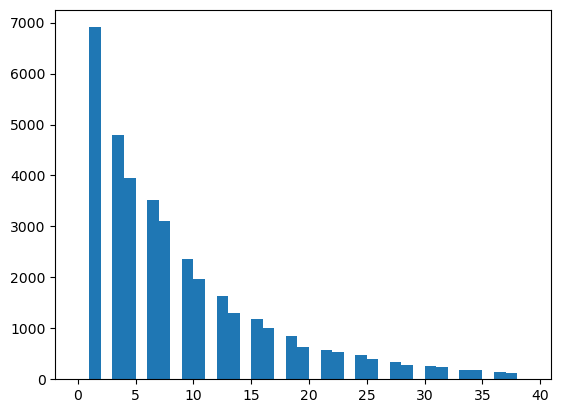

In [488]:
plt.hist(len_stops, bins=[x for x in range(40)]);

ModuleNotFoundError: No module named 'fitter'

This means that we want a constraint that we have to cross between 3 m/s and 2 m/s 9 times and the time spent below should be 2 minutes in total. We can also see that

In [474]:
mean_top_vel = sum(top_vel_list)/len(top_vel_list)

print("The average max vel between stops is", round(mean_top_vel,2), "m/s")

The average max vel between stops is 5.82 m/s


Which is higher than our mean velocity (5.0 m/s). The distribution of the max velocity reached between stops looks like this:

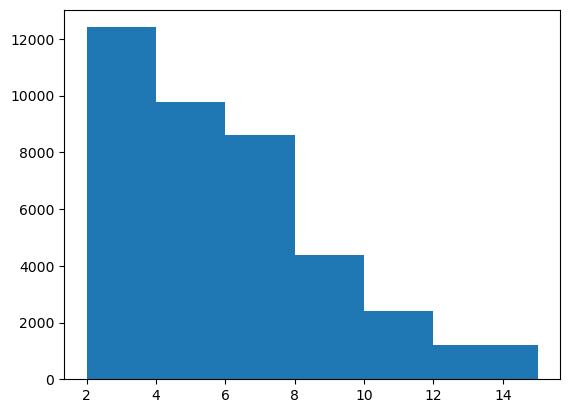

In [475]:
plt.hist(top_vel_list, bins=[2,4,6,8,10,12,15]);

So we could imagine implementing a constraint that it should reach mean vel between stops

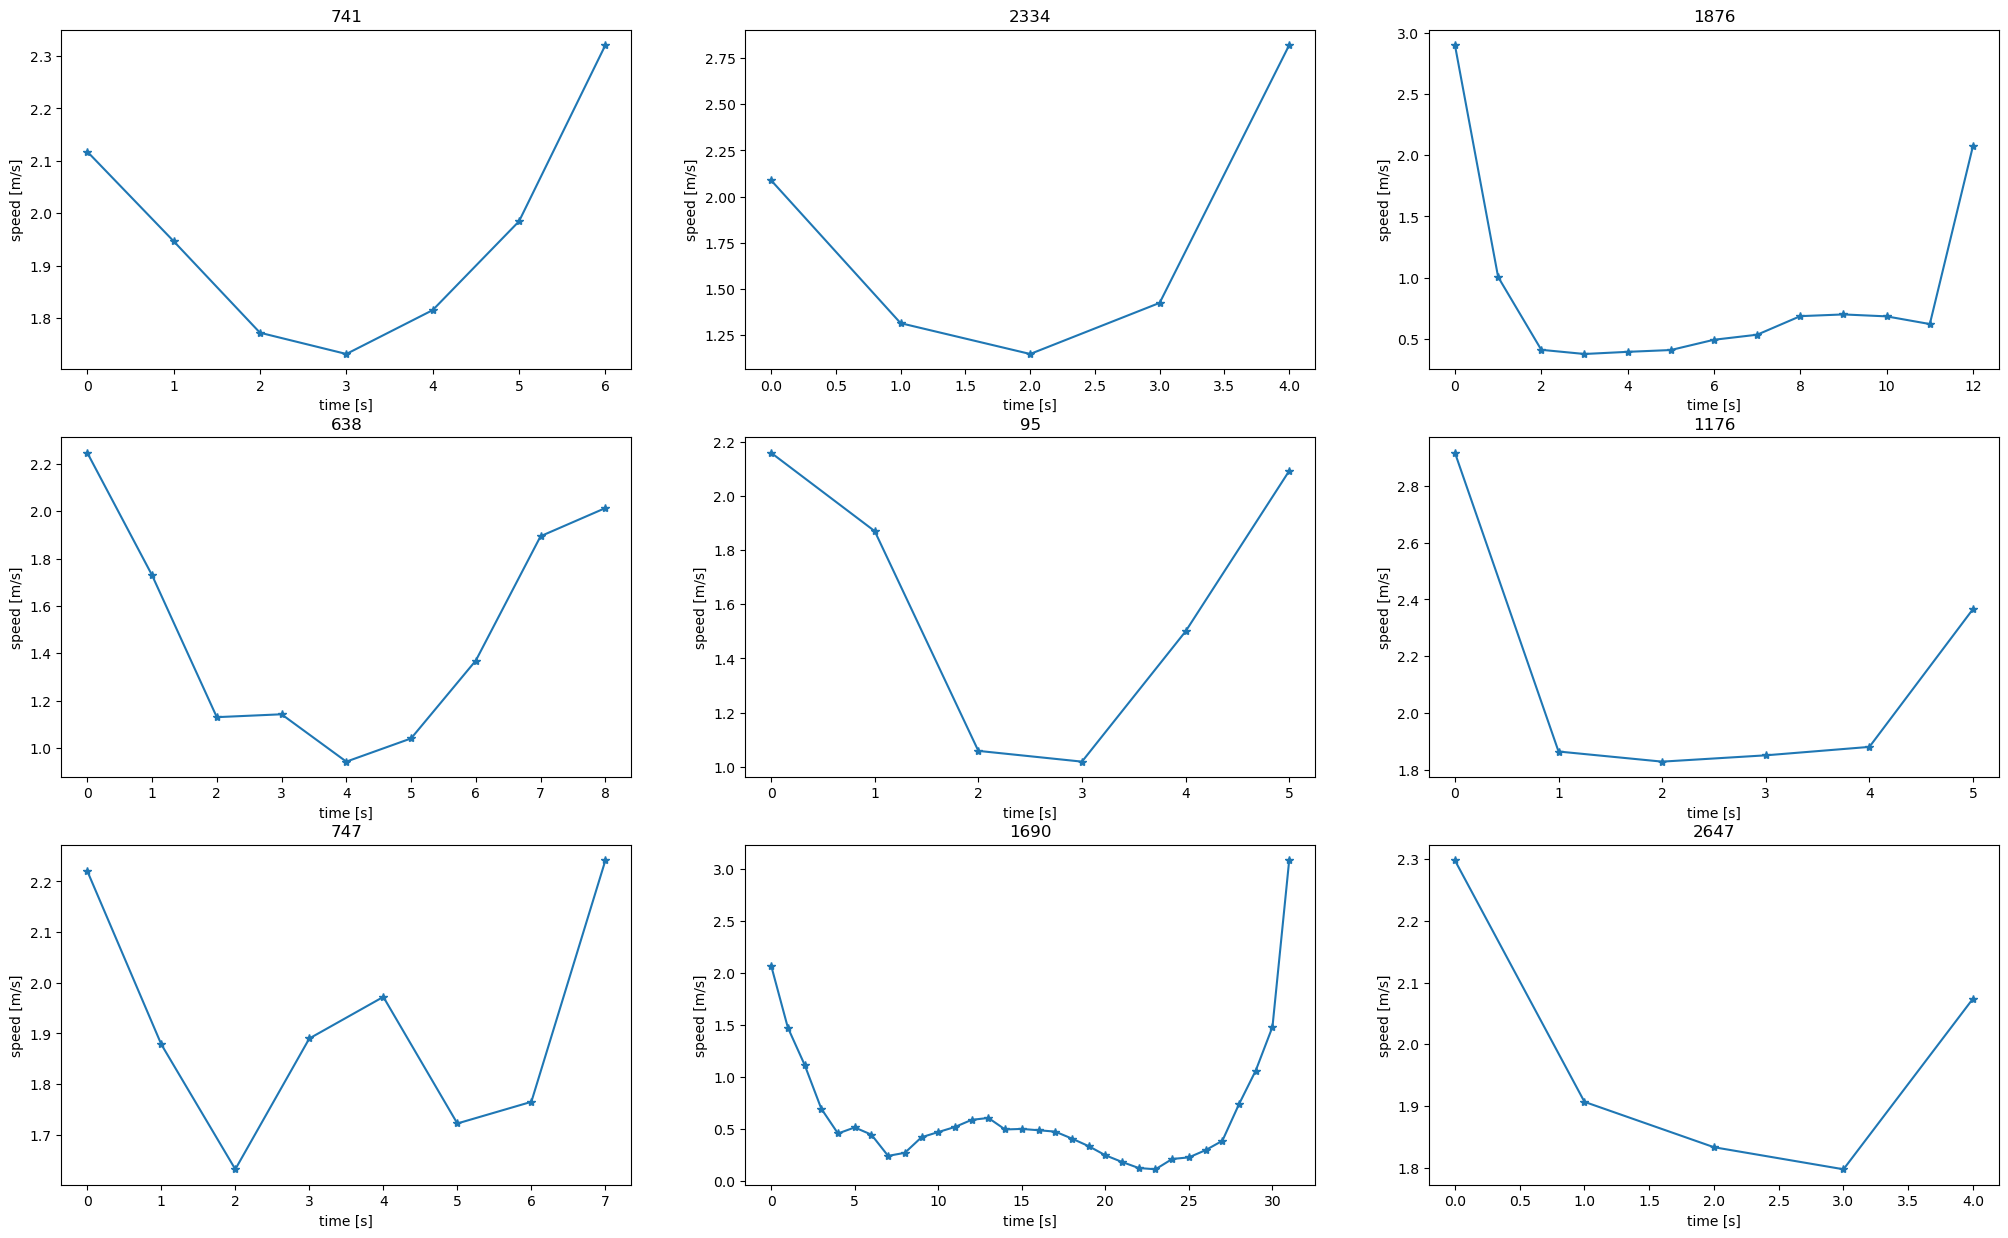

In [419]:
N = 9

stop_idx = [random.randint(0,len(stops)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(len(stop_idx)):
    one_stop = stops[stop_idx[i]]
    time = [x for x in range(len(stops[stop_idx[i]]))]

    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [s]")
    plt.ylabel("speed [m/s]")
    plt.plot(time, one_stop, "-*")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.title(str(stops_idx[stop_idx[i]]))

plt.show()

In [420]:
print("sooo prettty:", stop_idx[6])
print("with trip_id", stops_idx[23918])

sooo prettty: 7528
with trip_id 2376


In [819]:
trip = 2376
times = [x*60 for x in GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()]
vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
plt.xlabel("time [s]")
plt.ylabel("speed [m/s]")
plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
plt.xlim([0, 500])
plt.title("trip #"+str(trip))

plt.show()

10.705039665220404


## Is this the dataframe you have been looking for?


When you want to access only some of the data, this is how you do it:
The main tool is .loc; Pandas DataFrame.loc attribute access a group of rows and columns by label(s) or a boolean array in the given Pandas DataFrame. (There also an attribute called .iloc which access based on index.) 

I named our DataFrame GM. We can print the first two rows of our dataframe using

In [1300]:
GM.head(2)

geo  trip_id     length  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...        0   4.164946   
1  LINESTRING (-73.57751 45.50692, -73.57757 45.5...        0  12.379816   

     vel_og  time  Z_val_20       vel  vel_smooth  count  total_time  acc  \
0  2.758243  1.51 -0.986791  2.758243    0.551649     -1       9.966  NaN   
1  8.198554  1.51  0.092033  8.198554    2.191359     -1       9.966  NaN   

   acc_smooth  
0         NaN  
1         NaN

If we only want to look at some specific columns we dont use loc (I keep using head, because otherwise this explanation becomes very long).

In [1304]:
GM[["vel", "acc"]].head(2)

vel  acc
0  2.758243  NaN
1  8.198554  NaN

But say we only want to look at rows 20-22, we can use loc to do this

In [1305]:
GM.loc[[20,21,22]]

geo  trip_id     length  \
20  LINESTRING (-73.57764 45.50840, -73.57752 45.5...        0  18.968759   
21  LINESTRING (-73.57752 45.50852, -73.57742 45.5...        0  15.342079   
22  LINESTRING (-73.57742 45.50862, -73.57738 45.5...        0   6.769205   

       vel_og  time  Z_val_20        vel  vel_smooth  count  total_time  \
20  12.562092  1.51  0.957330  12.562092   11.684895     15       9.966   
21  10.160318  1.51  0.481054  10.160318   11.049639     16       9.966   
22   4.482917  1.51 -0.644785   4.482917    9.335950     17       9.966   

         acc  acc_smooth  
20 -1.590579   -0.420699  
21 -3.759868   -1.134893  
22 -0.149987   -0.291434

But what's great is that .loc accepts boolean statements like: only show rows where the velocity is higher than 20

In [1306]:
GM.loc[GM["vel_og"]>=20].head(2)

geo  trip_id    length  \
244  LINESTRING (-73.57796 45.51163, -73.57822 45.5...        0  32.84394   
245  LINESTRING (-73.57822 45.51177, -73.57851 45.5...        0  35.98217   

        vel_og  time  Z_val_20        vel  vel_smooth  count  total_time  \
244  21.750953  1.51    1000.0  11.335664   10.257273    239       9.966   
245  23.829251  1.51    1000.0  11.919022   10.775697    240       9.966   

         acc  acc_smooth  
244  0.38633    0.343328  
245  0.38633    0.376002

And if we want we can use more than one boolean statement (note the parenthesis and & sign)

In [1307]:
GM.loc[(GM["vel_og"]>=20) & (GM["Z_val_20"]<=100)]

Empty GeoDataFrame
Columns: [geo, trip_id, length, vel_og, time, Z_val_20, vel, vel_smooth, count, total_time, acc, acc_smooth]
Index: []

Here we get an empty dataframe, which is what we expect since all og velocities over 20 got assigned a z-value of 1000, since they where not used in generating z-scores. 

In [202]:
GM.head(1)

geo  trip_id    length  time  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...        0  4.164946  1.51   

     vel_og  Z_val_20       vel  vel_smooth  count  total_time  acc  \
0  2.758243 -0.986791  2.758243    0.551649   -1.0       9.966  NaN   

   acc_smooth  vel_smooth_test  acc_smooth_test  acc_og  
0         NaN         2.758243              NaN     NaN

In [260]:
#We make a copy so that we do not need to subindex like crazy (we also exclude all start and end-points)
GM_acc = GM.loc[(GM["count"] >= 0) & (GM["acc_smooth"] >= 0)][["trip_id", "total_time", "vel_smooth", "count", "acc_smooth"]].copy()

In [261]:
GM_acc["time_sum"] = GM_acc["count"]*1.51/60
GM_acc.drop("count", axis = 1, inplace = True)
#We replace "count" with "time_sum" which is the time the row takes place - in MINUTES 
#(so if count = 10, then it is the 10:th reading in that trip - i.e takes place at the 15:th second -> time_stamp=0.25)

In [262]:
GM_acc.head(3)

trip_id  total_time  vel_smooth  acc_smooth  time_sum
11        0       9.966    5.683668    0.005125  0.151000
12        0       9.966    5.691407    0.357779  0.176167
13        0       9.966    6.231653    0.138131  0.201333

In [263]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
#(In the first five minutes,.. etc.)
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [-np.inf, 5,10, 15, 20, 25, np.inf]

#name the bins (should be one less than bin_edges)
bin_labels = [5,10,15,20,25,30]

# This part does the grouping based on the input above
GM_acc[grouped_variable_name] = pd.cut(
    GM_acc[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10


In [264]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
#(In the first five minutes,.. etc.)
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [x for x in range(50)] + [np.inf]
bin_edges[0] = -1
bin_labels = [x for x in range(50)]


# This part does the grouping based on the input above
GM_acc[grouped_variable_name] = pd.cut(
    GM_acc[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10

In [265]:
GM_acc.head(3)

trip_id  total_time  vel_smooth  acc_smooth  time_sum section
11        0       9.966    5.683668    0.005125  0.151000       0
12        0       9.966    5.691407    0.357779  0.176167       0
13        0       9.966    6.231653    0.138131  0.201333       0

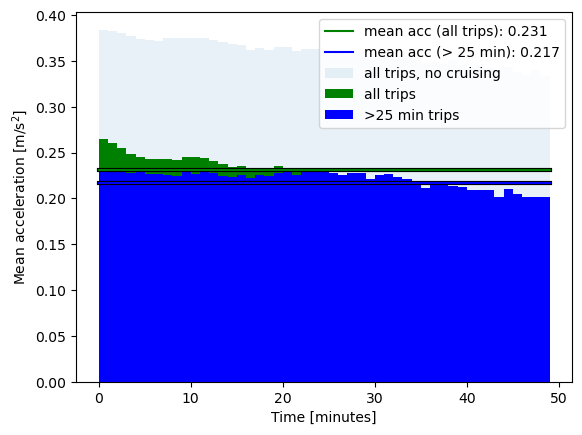

In [292]:
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM_acc.loc[(GM_acc["total_time"] >= 0) & (GM_acc["acc_smooth"] > 0.1) & (GM_acc["vel_smooth"] <= 10)].groupby("section")["acc_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips, no cruising", width=1, alpha=0.1)
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM_acc.groupby("section")["acc_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips", width=1, alpha = 1, color="green")
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM_acc.loc[GM_acc["total_time"] >= 25].groupby("section")["acc_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label=">25 min trips", width=1, alpha=1, color="blue")
plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], color="black", linewidth="3")
plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], label= "mean acc (all trips): " +str(round(GM_acc["acc_smooth"].mean(),3)), color="green")
plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], color="black", linewidth=3)
plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], label= "mean acc (> 25 min): " +str(round(GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean(),3)), color="blue")


plt.xlabel("Time [minutes]")
plt.ylabel("Mean acceleration [m/s$^2$]")
plt.legend()
plt.show()



In [185]:
#DONT RUN THIS; IT IS FOR INDIVIDUAL TRIPS AND TAKES FOREVER


trip_ids = GM_span.trip_id.unique().tolist() #get trip indexes
#GM_span["mean_vel"] = np.nan #create new empty column
                                                                 
comp = []

for trip_id in trip_ids:
    trip_comp = []
    overall_mean = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"] <= bin_labels[-2])]["acc_smooth"].mean()
    trip_comp.append(overall_mean)  
    for section in bin_labels[0:-1]:
        section_mean = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section)]["acc_smooth"].mean()
        if str(section_mean) != "nan":
            trip_comp.append(section_mean)
        else:
            trip_comp.append(overall_mean)
            print(trip_id)
        #GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section) , "mean_vel"] = GM_span.loc[(GM_span["trip_id"] == trip_id) & (GM_span["section"]==section)]["vel_smooth"].mean()
    comp.append(trip_comp)
    

per_comp = []
for trip_comp in comp:
    per_trip = []
    mean_trip = trip_comp[0]
    for elem in trip_comp[1::]:
        per_trip.append(elem/mean_trip)
        #per_trip.append(trip_comp[i] - mean_trip)
    per_comp.append(per_trip)

    
to_plot = []
for i in range(len(per_comp[0])):
    s = 0
    for per in per_comp:
        s+=per[i]
    to_plot.append(s)

k= sum(to_plot)
for i in range(len(per_comp[0])):
    to_plot[i] = to_plot[i]/k
    
print(to_plot)

[0.20392388687002452, 0.19934128193295167, 0.19767154088822736, 0.19736238795614694, 0.20170090235264948]


In [317]:
GM["time_sum"] = GM["count"]*1.51/60

In [318]:
#Here we simply set the bin-sizes for which section of the trip a row belongs to
#(In the first five minutes,.. etc.)
variable = "time_sum"  
grouped_variable_name = "section"

#set the edges of the bins
bin_edges = [x for x in range(50)] + [np.inf]
bin_edges[0] = -1
bin_labels = [x for x in range(50)]


# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e., if row i takes place during the first 10 minues of a trip, then row[i]["section"] = 10

In [320]:
plt.bar([x +0.5 for x in bin_labels[0:-1]], GM.loc[(GM["count"] >= 0) & (GM["total_time"] >= 0)].groupby("section")["vel_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips", width=1, alpha=0.3, color="red")

#plt.bar([x +0.5 for x in bin_labels[0:-1]], GM.loc[(GM["count"] >= 0)].groupby("section")["vel_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label="all trips", width=1, alpha = 1, color="green")

plt.bar([x +0.5 for x in bin_labels[0:-1]], GM.loc[(GM["count"] >= 0) & (GM["total_time"] >= 25)].groupby("section")["vel_smooth"].apply(lambda x: x.mean()).tolist()[0:-1], label=">25 min trips", width=1, alpha=0.3, color="blue")


#plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], color="black", linewidth="3")
#plt.plot([x for x in bin_labels], [GM_acc["acc_smooth"].mean() for x in bin_labels], label= "mean acc (all trips): " +str(round(GM_acc["acc_smooth"].mean(),3)), color="green")
#plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], color="black", linewidth=3)
#plt.plot([x for x in bin_labels], [GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean() for x in bin_labels], label= "mean acc (> 25 min): " +str(round(GM_acc.loc[GM_acc["total_time"] >= 25]["acc_smooth"].mean(),3)), color="blue")


plt.xlabel("Time [minutes]")
plt.ylabel("Mean velocity [m/s$^2$]")
plt.legend()
plt.show()

In [290]:
N = 3

#trip_ids = GM.trip_id.unique().tolist()
trips = [6,7,9]#[random.randint(0,len(trip_ids)) for x in range(N)]


#GM_span["time_sum"] = GM_span["count"]*1.51
fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trips[i]
    times = [1.51*x for x in GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["count"].tolist()]
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [s]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    for j in range(1,6):
        plt.axvline(x=j*5*60)
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 1500])
    plt.title("trip #"+str(trip))

plt.show()

In [300]:
GM.loc[(GM["trip_id"] == 6) & (GM["count"]>= 0)].head(3)# & (GM["count"] <= 15*60/1.5)  & (GM["count"] >= 10*60/1.5)].head(3)

geo  trip_id     length  \
2520  LINESTRING (-73.60618 45.53214, -73.60612 45.5...        6   6.515112   
2521  LINESTRING (-73.60612 45.53212, -73.60603 45.5...        6  12.588130   
2522  LINESTRING (-73.60603 45.53206, -73.60592 45.5...        6  13.520590   

      time    vel_og  Z_val_20       vel  vel_smooth  count  total_time  \
2520  1.51  4.314644 -0.984356  4.314644    6.749801    0.0   29.495333   
2521  1.51  8.336510  0.104078  8.336510    7.631306    1.0   29.495333   
2522  1.51  8.954033  0.271198  8.954033    7.393468    2.0   29.495333   

           acc  acc_smooth  vel_smooth_test  acc_smooth_test  
2520  2.663488    0.583778         5.630813         0.895926  
2521  0.408956   -0.157509         6.983661         0.652441  
2522 -2.220602   -0.685805         7.968847        -0.784080

In [305]:
GM_span.loc[(GM_span["trip_id"]==15) & (GM_span["section"] == 15)].head(10)

geo  trip_id    length  \
12206  LINESTRING (-73.59452 45.54560, -73.59452 45.5...       15  0.111195   

       time    vel_og  Z_val_20       vel  vel_smooth  count  total_time  \
12206  1.51  0.073639       0.0  0.073639     0.13784    8.0   41.952833   

            acc  acc_smooth  vel_smooth_test  acc_smooth_test  time_sum  \
12206  0.089168    0.005778         0.108336         0.033095     12.08   

      section  
12206      15

In [308]:
GM.head(3)

geo  trip_id     length  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...        0   4.164946   
1  LINESTRING (-73.57751 45.50692, -73.57757 45.5...        0  12.379816   
2  LINESTRING (-73.57757 45.50701, -73.57774 45.5...        0  19.563040   

   time     vel_og  Z_val_20        vel  vel_smooth  count  total_time  acc  \
0  1.51   2.758243 -0.986791   2.758243    0.551649   -1.0       9.966  NaN   
1  1.51   8.198554  0.092033   8.198554    2.191359   -1.0       9.966  NaN   
2  1.51  12.955656  1.035374  12.955656    4.782490   -1.0       9.966  NaN   

   acc_smooth  vel_smooth_test  acc_smooth_test  acc_og  
0         NaN         2.758243              NaN     NaN  
1         NaN         6.385117              NaN     NaN  
2         NaN        10.139710              NaN     NaN

In [313]:
GM.loc[(GM["count"]>= 0) & (GM["acc_smooth"]>0)]["acc_smooth"].mean()

0.23076310003194353

In [314]:
GM.loc[(GM["count"]>= 0) & (GM["acc"]>0)]["acc"].mean()

0.918752298127664

In [315]:
GM.loc[(GM["count"]>= 0) & (GM["acc_smooth_test"]>0)]["acc_smooth_test"].mean()

0.4370928145733857

geo  trip_id  \
5        LINESTRING (-73.57810 45.50729, -73.57827 45.5...        0   
6        LINESTRING (-73.57827 45.50740, -73.57836 45.5...        0   
7        LINESTRING (-73.57836 45.50745, -73.57843 45.5...        0   
8        LINESTRING (-73.57843 45.50748, -73.57847 45.5...        0   
9        LINESTRING (-73.57847 45.50752, -73.57845 45.5...        0   
...                                                    ...      ...   
4327023  LINESTRING (-73.54460 45.54177, -73.54463 45.5...     4880   
4327024  LINESTRING (-73.54463 45.54171, -73.54466 45.5...     4880   
4327025  LINESTRING (-73.54466 45.54166, -73.54468 45.5...     4880   
4327026  LINESTRING (-73.54468 45.54161, -73.54472 45.5...     4880   
4327027  LINESTRING (-73.54472 45.54157, -73.54475 45.5...     4880   

            length  time     vel_og  Z_val_20        vel  vel_smooth  count  \
5        22.361518  1.51  14.808952  1.402886  14.808952   13.545133    0.0   
6        11.144483  1.51   7.380453 -0.070198   7.380453   13.381513    1.0   
7         8.753379  1.51   5.796940 -0.384212   5.796940   11.949770    2.0   
8         6.223937  1.51   4.121812 -0.716392   4.121812    9.416160    3.0   
9         8.418565  1.51   5.575209 -0.428181   5.575209    7.536673    4.0   
...            ...   ...        ...       ...        ...         ...    ...   
4327023   6.876100  1.51   4.553709 -0.818228   4.553709    4.599923   44.0   
4327024   7.240115  1.51   4.794778 -0.669065   4.794778    4.715514   45.0   
4327025   5.673063  1.51   3.756995 -1.311200   3.756995    4.563075   46.0   
4327026   5.816702  1.51   3.852121 -1.252341   3.852121    4.332490   47.0   
4327027   7.518036  1.51   4.978832 -0.555181   4.978832    4.387287   48.0   

         total_time       acc  acc_smooth  vel_smooth_test  acc_smooth_test  \
5             9.966 -4.919536   -0.108358        13.545133        -2.403817   
6             9.966 -1.048684   -0.948174        13.381513        -1.714167   
7             9.966 -1.109356   -1.677887        11.949770        -1.407815   
8             9.966  0.962514   -1.244694         9.416160        -0.220116   
9             9.966  1.520466   -0.918919         7.536673         0.650708   
...             ...       ...         ...              ...              ...   
4327023       1.208  0.159648    0.076550         4.599923         0.033981   
4327024       1.208 -0.687273   -0.100953         4.715514        -0.326646   
4327025       1.208  0.062997   -0.152705         4.563075        -0.131825   
4327026       1.208  0.746166    0.036289         4.332490         0.307171   
4327027       1.208  0.371495    0.130607         4.387287         0.339333   

           acc_og  time_sum section  
5       -4.919536  0.000000       0  
6       -1.048684  0.025167       0  
7       -1.109356  0.050333       0  
8        0.962514  0.075500       0  
9        1.520466  0.100667       0  
...           ...       ...     ...  
4327023  0.159648  1.107333       1  
4327024 -0.687273  1.132500       1  
4327025  0.062997  1.157667       1  
4327026  0.746166  1.182833       1  
4327027  0.371495  1.208000       1  

[4277404 rows x 17 columns]

# AFTER OPT

In [498]:
import pickle

# Okay
The idea is to compare the results to some other stuff. The things to compare is
* OPT physics
* OPT constant
* OPT data

* Random
* best of five random trips



How to do this? 
* Should we use OG data or smoothed? Should we smooth after the fact? It feels wrong to not use OG data since we are using an acceleration function based on OG data. 
* Should we cut all histograms off over 10 m/s? Because otherwise they are hard to compare to each other. But then how to we compare that to the random trips we choose? Actually, this is not a problem for the 5 random trips choosen. But keep in mind.

## Plan
First issue, the trips have a timestep op 1.51 seconds. We would like to change this so that it is 2 seconds. OR we just scale the histograms so that

# this is the histogram we are working with!!!

OG data 

In [1329]:
H_scaled = [4.512743388441156, 4.273652521789638, 4.076151085825884, 4.050617109775722, 3.776513745661481, 3.751560087248823, 3.8283554546118106, 4.079439552438405, 4.4003552059779425, 4.422213836990581, 4.6798748680422175, 4.7874270701929005, 4.483534067353471, 4.657822797817078, 4.727654353530021, 4.802902207192999, 4.942371879406385, 5.279923305221028, 5.383219844696684, 5.770872026549146, 6.177287812014226, 6.458935305416015, 6.8469743656934785, 7.375450294246835, 7.64394392119854, 8.330266247152897, 8.749062142218058, 9.519143647185448, 10.012607078276082, 10.561394124142065, 11.172081718008444, 11.865174416400345, 12.09285236951429, 12.838173655281523, 13.359685772184836, 13.770163781112442, 14.083922183789435, 14.604273665417738, 15.27705524649701, 15.54477511659871, 15.851569707625659, 15.914050573263555, 15.973242972288931, 16.013478328489185, 16.06783474720203, 15.7792234421502, 15.812688425912912, 15.61866889577418, 15.558702739898798, 15.046282265983045, 14.85980686513186, 14.618975045567831, 13.858372062013002, 13.710777942874564, 13.332023964797159, 12.778400938618644, 12.2990585700406, 11.783349629512326, 11.448893231097701, 10.731040313505643, 10.260015831065152, 9.876425872675217, 9.318547183821673, 8.845201430831167, 8.550593510191797, 8.010124350463364, 7.583590886898157, 7.294786142633822, 6.818925679880801, 6.469574462103583, 6.128734569676418, 5.814202410149421, 5.542226877372694, 5.231176623670718, 4.926703303193785, 4.695156565829815, 4.529379160716262, 4.274619717852144, 4.242895687001942, 3.923527547162415, 3.7165475897861002, 3.6716696924858154, 3.510341389259791, 3.390602516721531, 3.1905863709952604, 3.174917794782661, 2.982058899918936]
vel = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6]

# Random

In [1129]:
random_route = []
vel_list = [round(x) for x in H_scaled]

for i in range(len(vel_list)):
    v_curr = vel[i]
    for j in range(vel_list[i]):
        random_route.append(v_curr)
random.shuffle(random_route)

rand_df = pd.DataFrame(random_route, columns=['vel'])
rand_df["time"] = [2*x for x in range(len(random_route))]
rand_df["vel_smooth"] = rand_df["vel"].rolling(5).mean()

v_use = ["vel", "vel_smooth"]
acc_name = ["acc", "acc_smooth"]
for i in range(2):
    rand_df[acc_name[i]] = -rand_df[v_use[i]].diff(periods=-1)
    rand_df[acc_name[i]] = rand_df.loc[:, (acc_name[i])]/2

rand_df.dropna(inplace = True)

variable = "vel_smooth"  
grouped_variable_name = "vel_smooth_bin"

rand_df[grouped_variable_name] = pd.cut(
    rand_df[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [1134]:
rand_df.head(2)

vel  time  vel_smooth   acc  acc_smooth vel_smooth_bin
4  0.7     8        4.02  2.85        0.16             40
5  6.4    10        4.34 -1.80       -0.21             43

In [1457]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data", width=0.1)
plt.bar(vel, rand_df.groupby("vel")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

<BarContainer object of 87 artists>

# random trips

In [1095]:
trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()

In [1319]:
N_trip = 3
trips = [1011, 91, 915, 1390, 1192] #random

trips_df_list = []
for i in range(N_trip):
    trip = trips[i]
    trips_df = pd.DataFrame(GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)]["time_sum"].tolist(), columns=['time_sum'])
    cols = ["vel", "acc", "vel_smooth", "acc_smooth", "vel_bin", "vel_OG_bin"]

    for col in cols:
        trips_df[col] = GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)][col].tolist()

    trips_df.rename(columns={'vel_bin': 'vel_smooth_bin'}, inplace=True)
    trips_df.rename(columns={'vel_OG_bin': 'vel_bin'}, inplace=True)
    trips_df_list.append(trips_df)

In [1320]:
trips_df_list[0].head(3)

time_sum       vel       acc  vel_smooth  acc_smooth  vel_smooth_bin  \
0  0.000000  3.618448  0.091599    2.982183    0.252267              30   
1  0.025167  3.756762  2.153695    3.363106    0.549318              34   
2  0.050333  7.008841 -2.242281    4.192577    0.056646              42   

   vel_bin  
0       37  
1       38  
2       71

## Compare the three trips here

we need to scale the histogram so that it matches sum(H_trips) instead of 750

In [1321]:
c = 994/750
H_trips = [x*c for x in H_scaled]

In [1466]:
tr = 2
trips_df = trips_df_list[tr]

In [1470]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data (scaled)", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="trip #"+str(trips[tr]), width=0.1, alpha = 0.5)
#plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

We can combine their velocities into one histogram (and scale it to 750)

In [1503]:
comb_H = [0 for x in range(100)]

for trips_df in trips_df_list:
    h = trips_df.groupby("vel_bin")["vel_bin"].count().reindex([x for x in range(100)], fill_value=0)
    for i in range(100):
        comb_H[i] += h[i]/N_trip

c = 750/sum(comb_H)
comb_H = [x*c for x in comb_H]
print("scaled:", round(sum(comb_H)), round(sum(H_scaled)))

scaled: 750 750


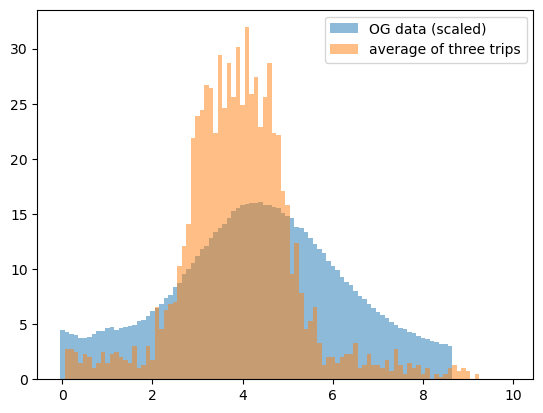

In [1471]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H, label="average of three trips", alpha=0.5, width=0.1)
plt.legend()
plt.show()

# optimized trip

In [80]:
#runs = ["phys_wStops", "phys_noStops", "phys_wStops_OG", "const_cut_87_OG"]
runs = ["OPT_physics", "OPT_constant", "OPT_data"]
#runs = ["phys_wStops_OG", "const_cut_87_OG", "dist_cut_87_OG"]
#runs = ["OPT_physics", "phys_wStops_OG"]
opt_df_list = []

for name in runs:
    with open(name+".pickle", 'rb') as handle: #open
        x_val_dic = pickle.load(handle)

    x_val = x_val_dic[0][1::] #the first elem in list is opt-val - not a velocity
    opt_df = pd.DataFrame(x_val, columns=['vel'])
    opt_df["time"] = [2*x for x in range(len(x_val))]


    opt_df["vel_smooth"] = opt_df["vel"].rolling(5).mean()

    v_use = ["vel", "vel_smooth"]
    acc_name = ["acc", "acc_smooth"]
    for i in range(2):
        opt_df[acc_name[i]] = -opt_df[v_use[i]].diff(periods=-1)
        opt_df[acc_name[i]] = opt_df.loc[:, (acc_name[i])]/2

    opt_df.dropna(inplace = True)

    variable = "vel_smooth"  
    grouped_variable_name = "vel_smooth_bin"

    opt_df[grouped_variable_name] = pd.cut(
        opt_df[variable],
        bins= vel + [np.inf],
        labels= [x for x in range(len(vel))],
        right=False) 
    opt_df_list.append(opt_df)

FileNotFoundError: [Errno 2] No such file or directory: 'OPT_physics.pickle'

In [1517]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
for i in range(len(runs)):
    opt_df = opt_df_list[i]
    lab = runs[i]
    plt.bar(vel, opt_df.groupby("vel")["vel"].count().tolist(), label=lab,alpha=0.5,width=0.1)
plt.legend()
plt.show()


# Compare

# Not smoothed

In [1519]:
print("mean velocity:")
print("OG data:", round(GM.loc[GM["vel"]<=8.6]["vel"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel"].mean(),2))
print("random:", round(rand_df["vel"].mean(),2))
print("three trips:", round((trips_df_list[0]["vel"].mean() + trips_df_list[1]["vel"].mean() + trips_df_list[2]["vel"].mean())/3,2))


mean velocity:
OG data: 4.37
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.35
three trips: 3.86


In [1521]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)
            

In [1522]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 46.31 %
OPT_constant 53.83 %
OPT_data 50.2 %
OG 41.93 %
RANDOM 46.73 %
three trips 31.79 %

time spent decelerating:
OPT_physics 30.47 %
OPT_constant 33.29 %
OPT_data 36.91 %
OG 36.24 %
RANDOM 46.06 %
three trips 31.12 %

time spent cruising:
OPT_physics 23.22 %
OPT_constant 12.89 %
OPT_data 12.89 %
OG 21.83 %
RANDOM 7.21 %
three trips 37.09 %


## number of stops
Since I've all but dropped "smoothed" data, the number of stops should now instead be defined from the OG data. So the number of stops *should* be 31.. (we could also check whether the smoothed OPT is close to 9 stops?)

In [1511]:
#state 0 means we are in a "stop-period"
#state 1 means we are in a "drive-period"

max_vel = 2#limit for what is considered "stop"
velocities = opt_df_list[0]["vel"].tolist()
stops = []    #list to save all stop-periods

state = 1     #we start in a drive-period (I know this because I know the data, might have to change if other data is used)
one_stop = [] #list to save all velocities for one stop-period




for i in range(1, len(velocities)): 
    v = velocities[i]                  #current vel
    
    if state == 0 and v < max_vel:    #we are in a stop-period and we stay there
        one_stop.append(v)             #keep adding "stop-period"-velocities, 
        #state = 0                     #stay in state
        
    elif state == 0 and v >= max_vel:   #we are leaving a stop-period
        one_stop.append(v)         #add vel *just after* stop-period
        stops.append(one_stop)     #save this stop
        state = 1                  #change state
            
    elif state == 1 and v < max_vel:   #we are entering a stop-period
        one_stop = [velocities[i-1], v]#add vel *just before* stop-period AND first vel *in* stop-period
        state = 0
    else: #state = 1 v > 1
        state = 1
print(len(stops))

31


##  stops
* All OPTs has (predictably) 31 stops
* random has 82
* trip 1: 13, trip 2: 16, trip 3: 18

# anything else to compare?

* speed vs acceleration?

In [1512]:
opt_df

vel  time  vel_smooth   acc  acc_smooth vel_smooth_bin
4    2.7     8        1.94  0.40        0.35             19
5    3.5    10        2.64  0.45        0.29             26
6    4.4    12        3.22  0.40        0.30             32
7    5.2    14        3.82  0.15        0.22             38
8    5.5    16        4.26 -1.75       -0.07             42
..   ...   ...         ...   ...         ...            ...
744  3.6  1488        3.48  0.40        0.01             34
745  4.4  1490        3.50 -0.25        0.06             35
746  3.9  1492        3.62 -0.15        0.07             36
747  3.6  1494        3.76  0.20        0.07             37
748  4.0  1496        3.90 -2.00       -0.36             39

[745 rows x 6 columns]

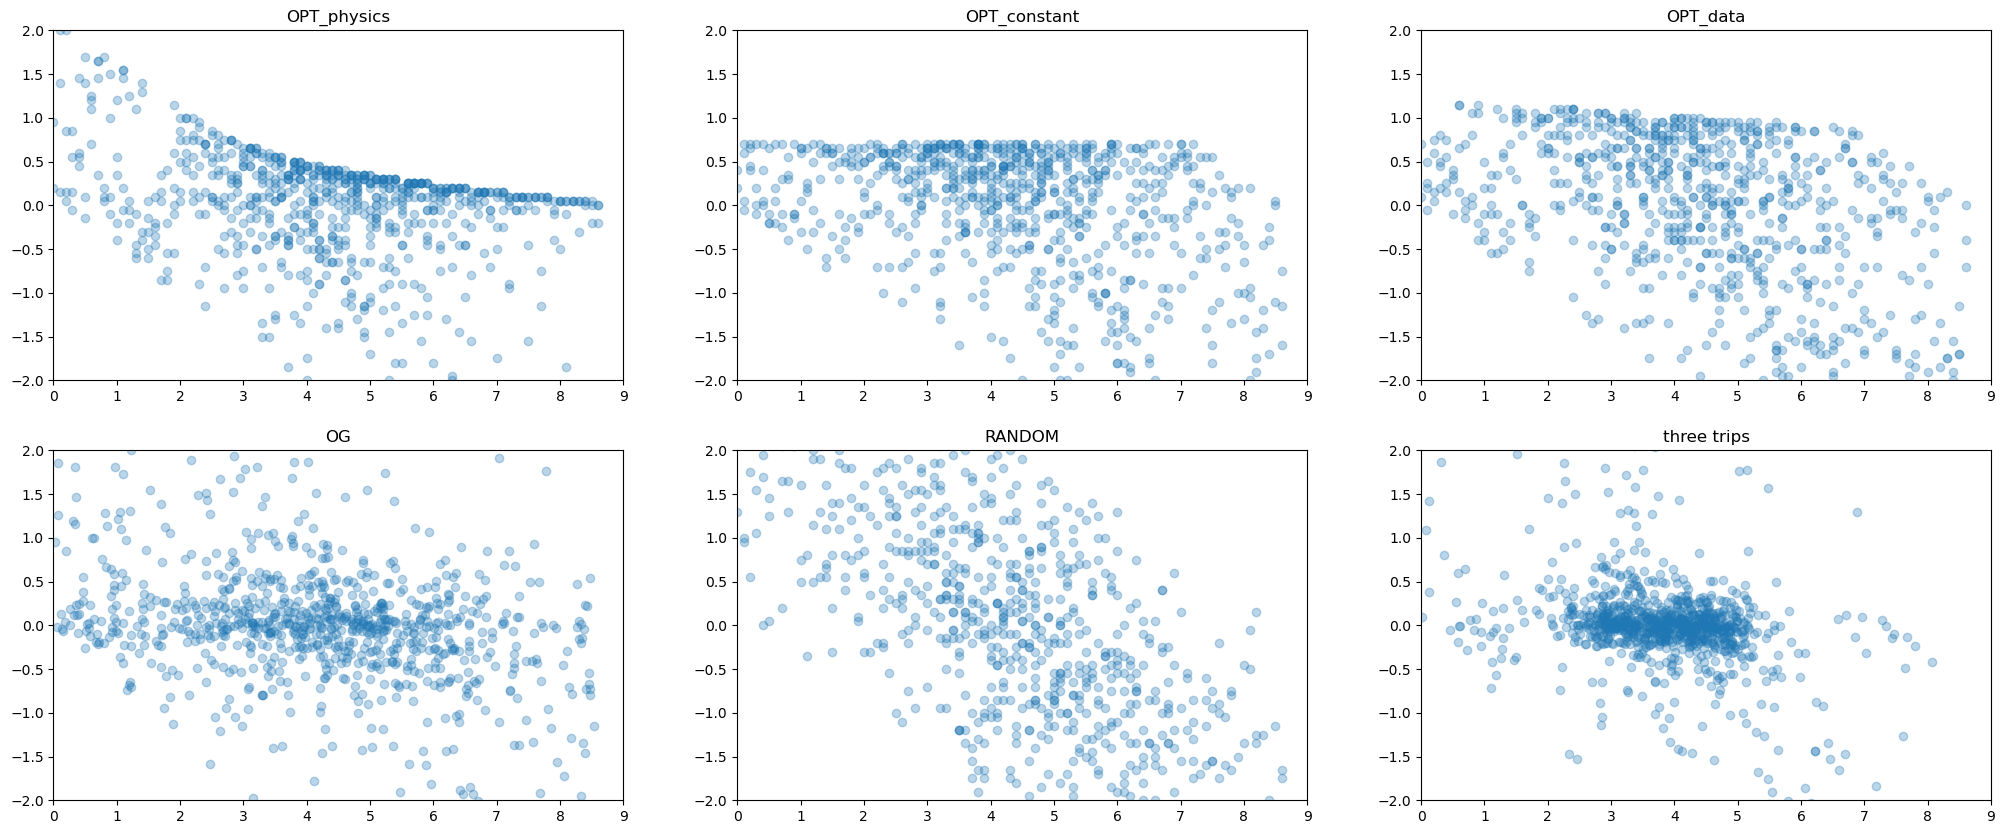

In [1536]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel'], 
           y=frame['acc'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel"],
                y=sub_frame["acc"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])

plt.show()

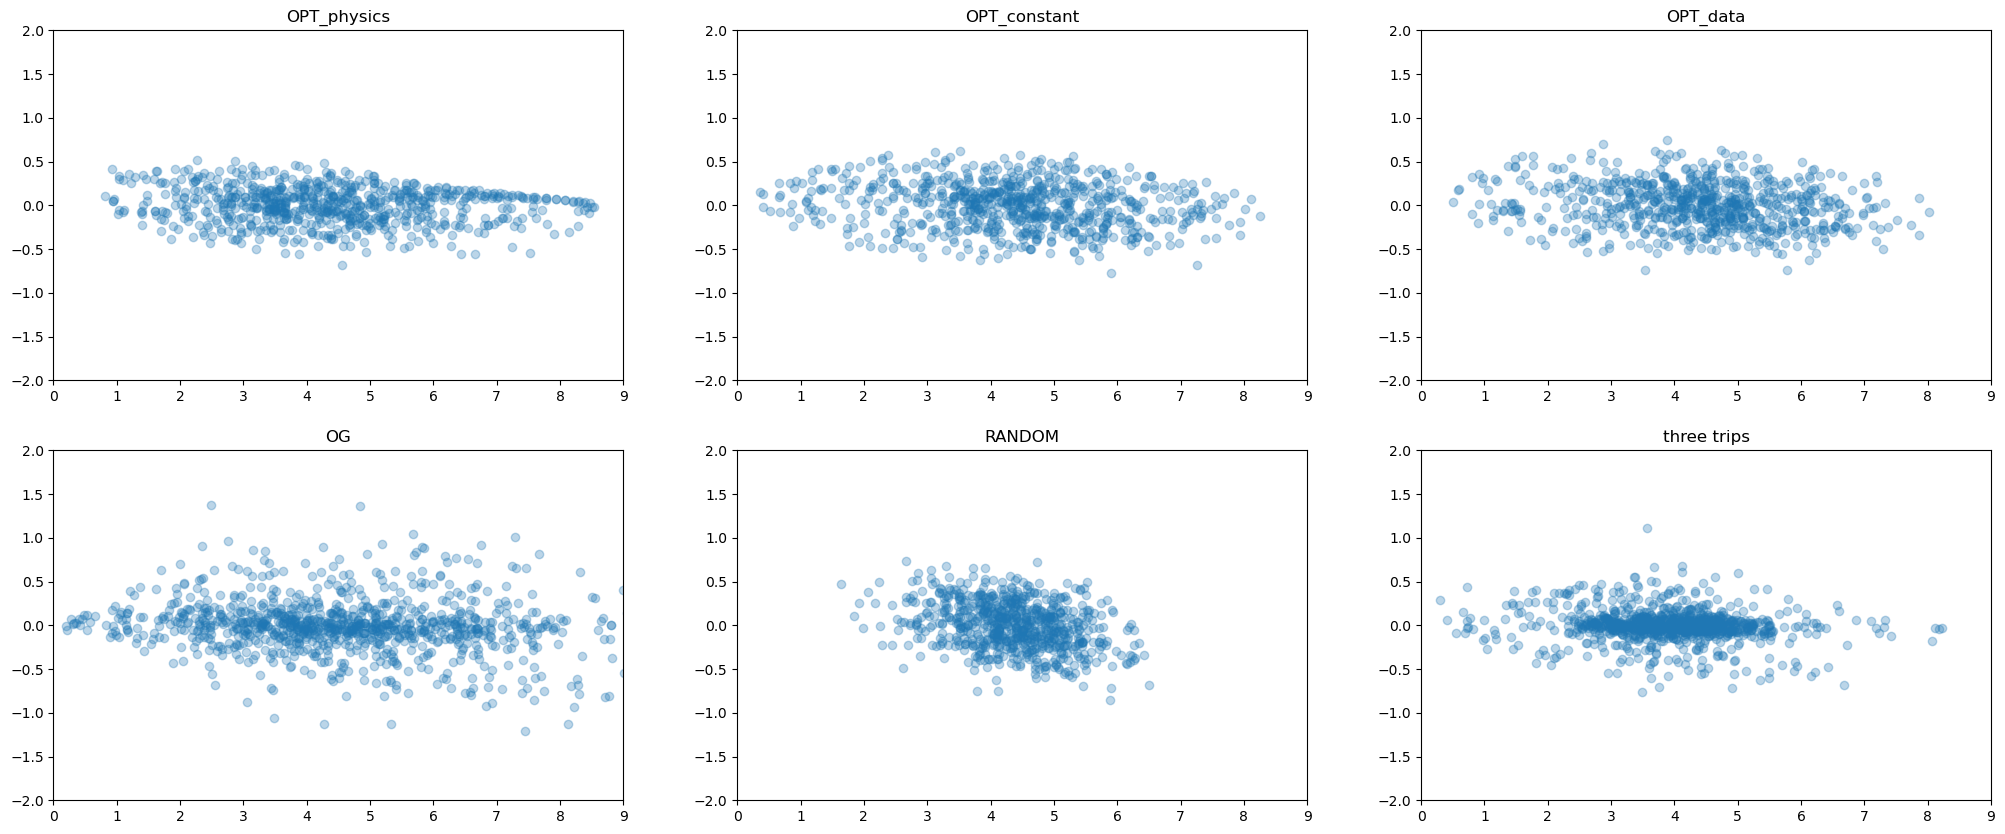

In [1535]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel_smooth'], 
           y=frame['acc_smooth'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel_smooth"],
                y=sub_frame["acc_smooth"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])


plt.show()

# SMOOTH (not now)

In [1326]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]




In [1546]:
compare_H = H_scaled + [0 for x in range(len(comb_H)-len(H_scaled))]
comb_H = comb_H
opt_H = opt_df_list[2].groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
rand_H = rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
comb_abs = 0
opt_abs = 0
rand_abs = 0
for i in range(len(comb_H)):
    x = compare_H[i]
    comb_abs += abs(x-comb_H[i])
    opt_abs += abs(x-opt_H[i])
    rand_abs += abs(x-rand_H[i])
print(comb_abs)
print(opt_abs)
print(rand_abs)

In [1549]:
print("mean velocity:")
print("OG data:", round(GM.loc[GM["vel_smooth"]<=8.6]["vel_smooth"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel_smooth"].mean(),2))
print("random:", round(rand_df["vel_smooth"].mean(),2))
print("three trips:", round((trips_df_list[0]["vel_smooth"].mean() + trips_df_list[1]["vel_smooth"].mean() + trips_df_list[2]["vel_smooth"].mean())/3,2))


mean velocity:
OG data: 4.64
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.36
three trips: 3.86


In [1552]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc_smooth"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc_smooth"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc_smooth"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc_smooth"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)

In [1553]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 31.41 %
OPT_constant 36.38 %
OPT_data 33.42 %
OG 27.6 %
RANDOM 34.98 %
three trips 18.48 %

time spent decelerating:
OPT_physics 29.26 %
OPT_constant 35.03 %
OPT_data 34.36 %
OG 28.27 %
RANDOM 36.18 %
three trips 18.21 %

time spent cruising:
OPT_physics 39.33 %
OPT_constant 28.59 %
OPT_data 32.21 %
OG 44.12 %
RANDOM 28.84 %
three trips 63.31 %


In [ ]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="OG", width=0.1, alpha = 0.5)
plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

In [ ]:
plt.bar([x for x in vel], H_scaled,alpha=1,label="OG data", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H,alpha=0.5,label="all three smooth", width=0.1)
plt.bar(vel, opt_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="opt",alpha=0.5,width=0.1)

plt.legend()
plt.show()

# print histogram for optimization

In [500]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [508]:
print(GM.loc[GM["count"] >= 0].groupby("vel_bin").agg("count")["vel_smooth"].tolist())

[2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82,

OG data

In [977]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_OG_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [978]:
print(GM.loc[GM["count"] >= 0].groupby("vel_OG_bin").agg("count")["vel"].tolist())

[23329, 22093, 21072, 20940, 19523, 19394, 19791, 21089, 22748, 22861, 24193, 24749, 23178, 24079, 24440, 24829, 25550, 27295, 27829, 29833, 31934, 33390, 35396, 38128, 39516, 43064, 45229, 49210, 51761, 54598, 57755, 61338, 62515, 66368, 69064, 71186, 72808, 75498, 78976, 80360, 81946, 82269, 82575, 82783, 83064, 81572, 81745, 80742, 80432, 77783, 76819, 75574, 71642, 70879, 68921, 66059, 63581, 60915, 59186, 55475, 53040, 51057, 48173, 45726, 44203, 41409, 39204, 37711, 35251, 33445, 31683, 30057, 28651, 27043, 25469, 24272, 23415, 22098, 21934, 20283, 19213, 18981, 18147, 17528, 16494, 16413, 15416, 14443, 14583, 13872, 13642, 12876, 12715, 12046, 11315, 11560, 11098, 10765, 10631, 10317, 9907, 9715, 9631, 9218, 8668, 8573, 8587, 8261, 8003, 7927, 7415, 7206, 6962, 6597, 6219, 6345, 5881, 5935, 5300, 5307, 5242, 4754, 4645, 4357, 4117, 3980, 3849, 3643, 3423, 3259, 2992, 2903, 2714, 2544, 2449, 2336, 2161, 2007, 1851, 1846, 1714, 1636, 1517, 1418, 1242, 1182, 1122, 1005, 992, 905, 8

# PP plots

In [586]:
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

In [ ]:
color1=mcp.gen_color(cmap="viridis",n=4)

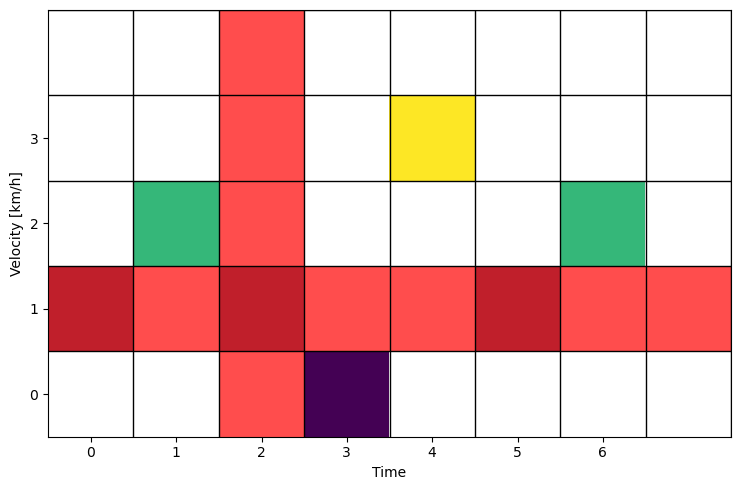

In [975]:
N = 8 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data
data2 = np.ones((M,N))*np.nan

def trip_1(order_list):
    data[0][order_list[0]] = 0 #[y][x]
    data[1][order_list[1]] = 1 #[y][x]
    data[1][order_list[2]] = 1 #[y][x]
    data[1][order_list[3]] = 1 #[y][x]
    data[2][order_list[4]] = 2 #[y][x]
    data[2][order_list[5]] = 2 #[y][x]
    data[3][order_list[6]] = 3 #[y][x]
    sss = 3

    
def const1():
    for i in range(5):
        data2[i][2] = 4
    for i in range(8):
        data2[1][i] = 4
#order_list = [0,1,2,3,4,5,6]
#random.shuffle(order_list)

trip_1(order_list)

a = const1()



# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[0:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)


my_cmap2 = colors.ListedColormap(mcp.gen_color(cmap="hsv",n=1))
# set the 'bad' values (nan) to be white and transparent
my_cmap2.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
plt.xlabel("Time")
plt.ylabel("Velocity [km/h]")

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
ax.imshow(data2, interpolation='none', cmap=my_cmap2, zorder=0, origin='lower', alpha = 0.7);
# turn off the axis labels
#ax.axis('off')

In [817]:
N = 4 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data


# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[3:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
#for x in range(N + 1):
#    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
#    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N, dtype=np.int64))
plt.yticks(np.arange(0, M, dtype=np.int64))


def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-0.5, y), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


#data[0][0]=0
#highlight_cell(0,0, color="black", linewidth=1)

#data[0][1]=1
#highlight_cell(1,0, color="black", linewidth=1)

#data[1][1]=1
#highlight_cell(1,1, color="black", linewidth=1)

#data[2][1]=1
#highlight_cell(1,2, color="black", linewidth=1)

#data[0][2]=2
#highlight_cell(2,0, color="black", linewidth=1)

#data[1][2]=2
#highlight_cell(2,1, color="black", linewidth=1)

#data[0][3]=3
#highlight_cell(3,0, color="black", linewidth=1)

ax.imshow(data, interpolation='none', cmap=my_cmap,extent=[-0.5,N-0.5,0,M], zorder=0, origin='lower')
plt.xlabel("Velocity [km/h]")
plt.ylabel("Count")

plt.show()
# turn off the axis labels
#ax.axis('off')

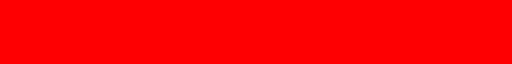

In [676]:
order_list = [0,1,2,3,4,5,6]



None


In [700]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "plt_vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

H_tilf = GM.loc[GM["count"] >= 0].groupby("plt_vel_bin").agg("count")["vel_smooth"].tolist()

In [726]:
#H_tilf = [2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82, 62, 52, 57, 36, 50, 37, 29, 27, 33, 28, 22, 28, 19, 24, 28, 14, 24, 20, 16, 22, 16, 16, 20, 14, 34, 24, 22, 19, 23, 38, 33, 30, 40, 45, 59, 73, 68, 74, 55, 140, 131, 85, 3]
H_scaled = [round(x/sum(H_tilf)*25) for x in H_tilf][0:10]



In [727]:
print(H_scaled)

[1, 1, 2, 4, 5, 4, 3, 2, 1, 1]


In [711]:
from mycolorpy import colorlist as mcp

In [728]:
color1=mcp.gen_color(cmap="viridis",n=len(H_scaled))
print(color1)

['#440154', '#482878', '#3e4989', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6ece58', '#b5de2b', '#fde725']


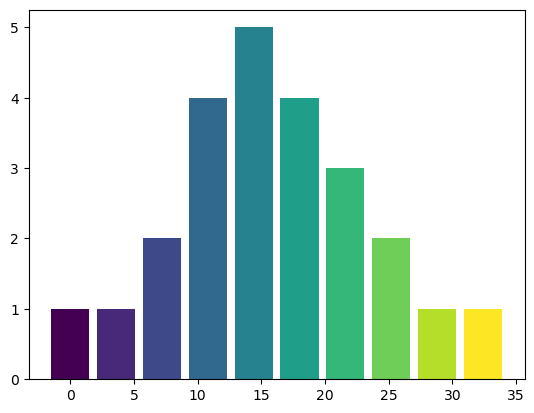

In [729]:
vel_km = [round(x/1*60*60/1000,2) for x in range(len(H_scaled))]
plt.bar(vel_km,H_scaled, color=color1, width=3)
plt.show()

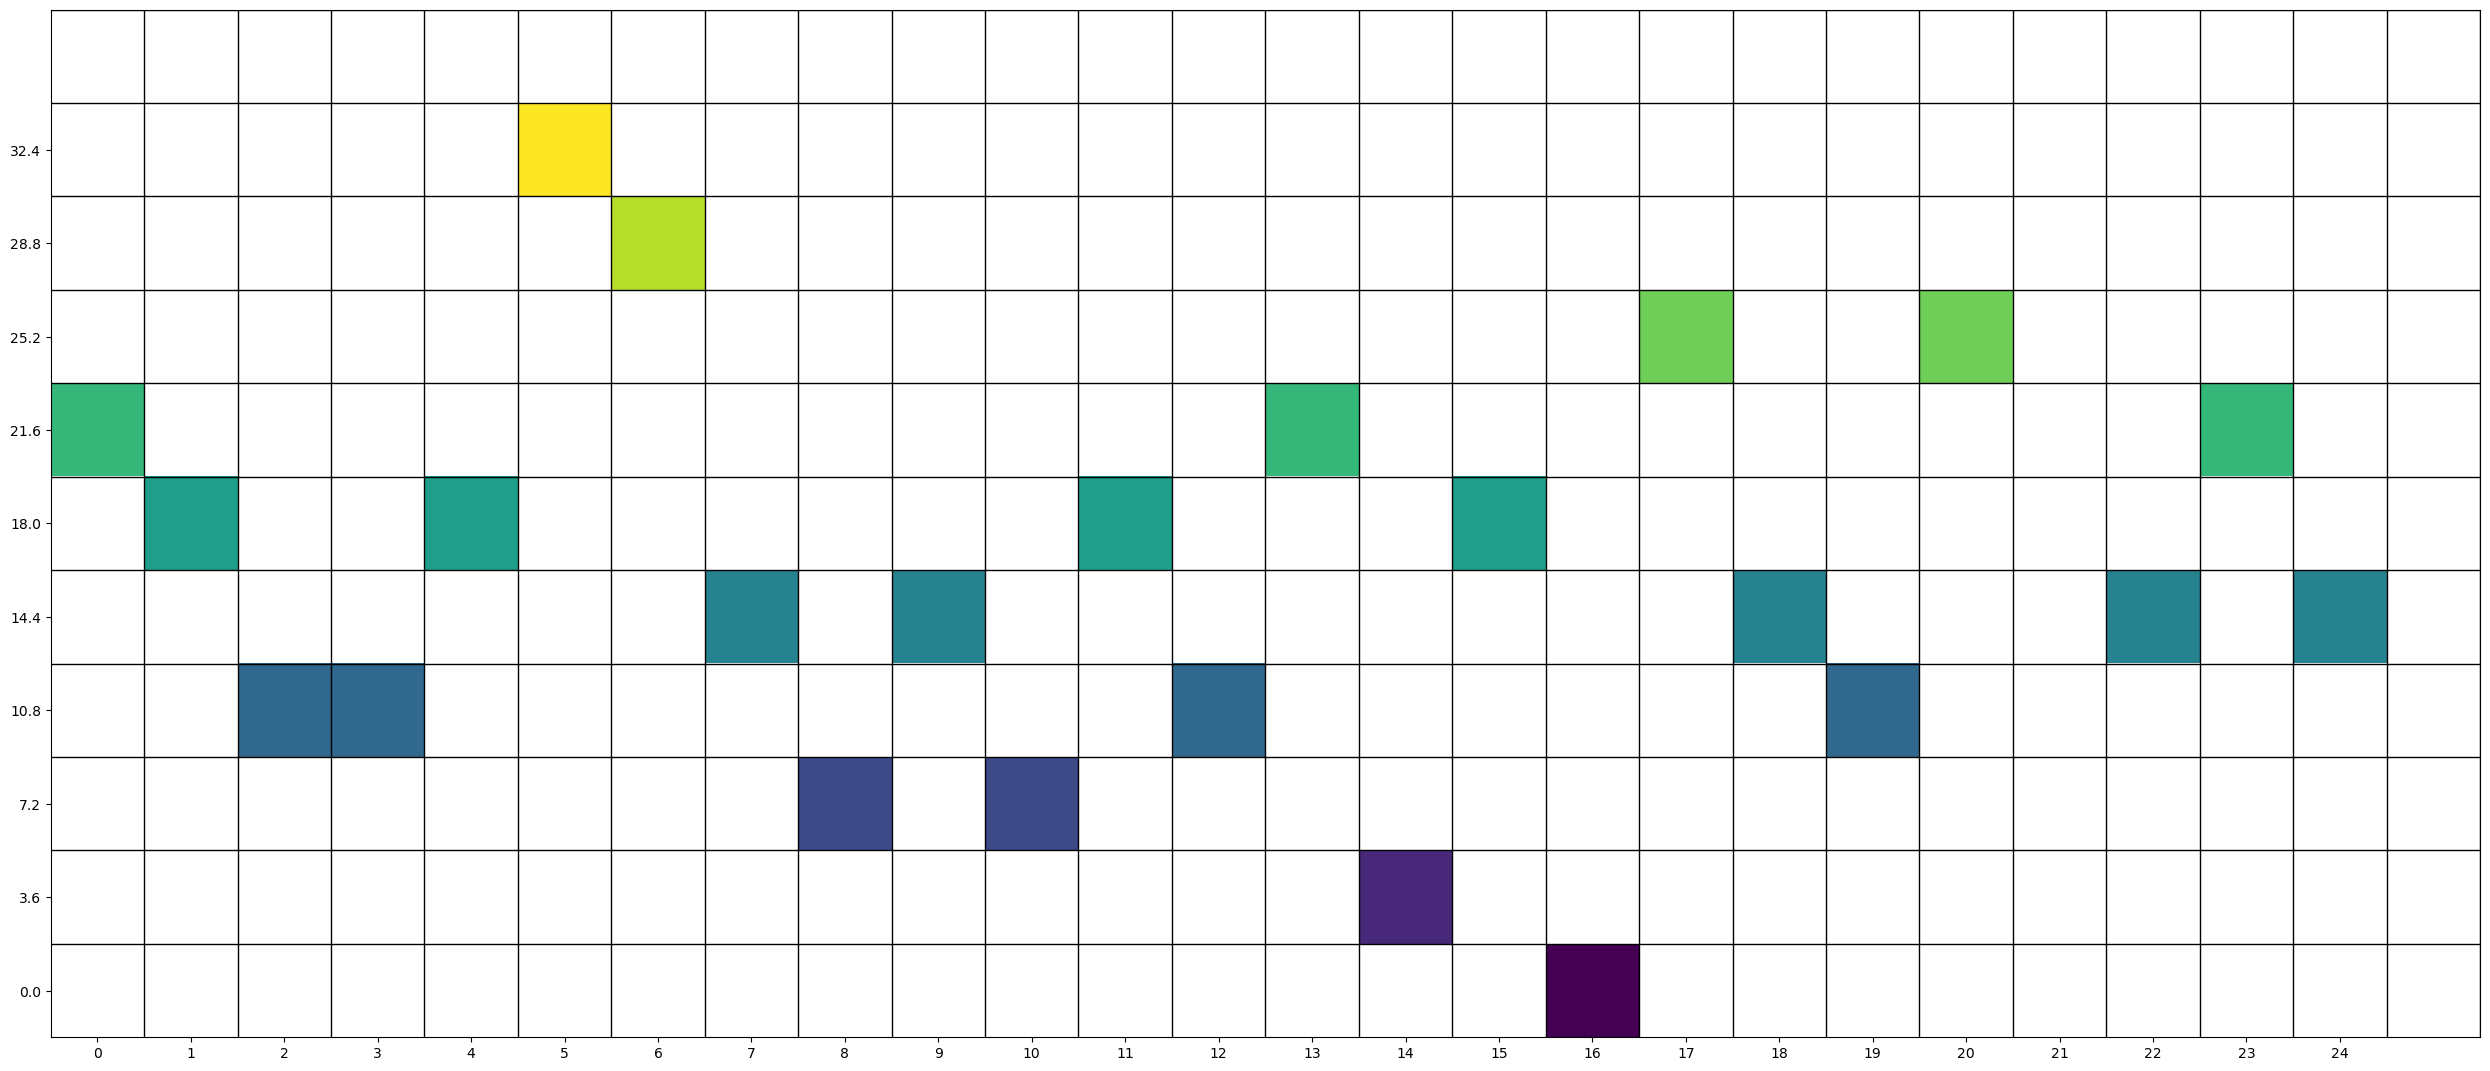

In [750]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data



def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


order_list = [x for x in range(25)]
random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
# turn off the axis labels
#ax.axis('off')

In [ ]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data



def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


order_list = [x for x in range(25)]
random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower')
plt.show()
# turn off the axis labels
#ax.axis('off')

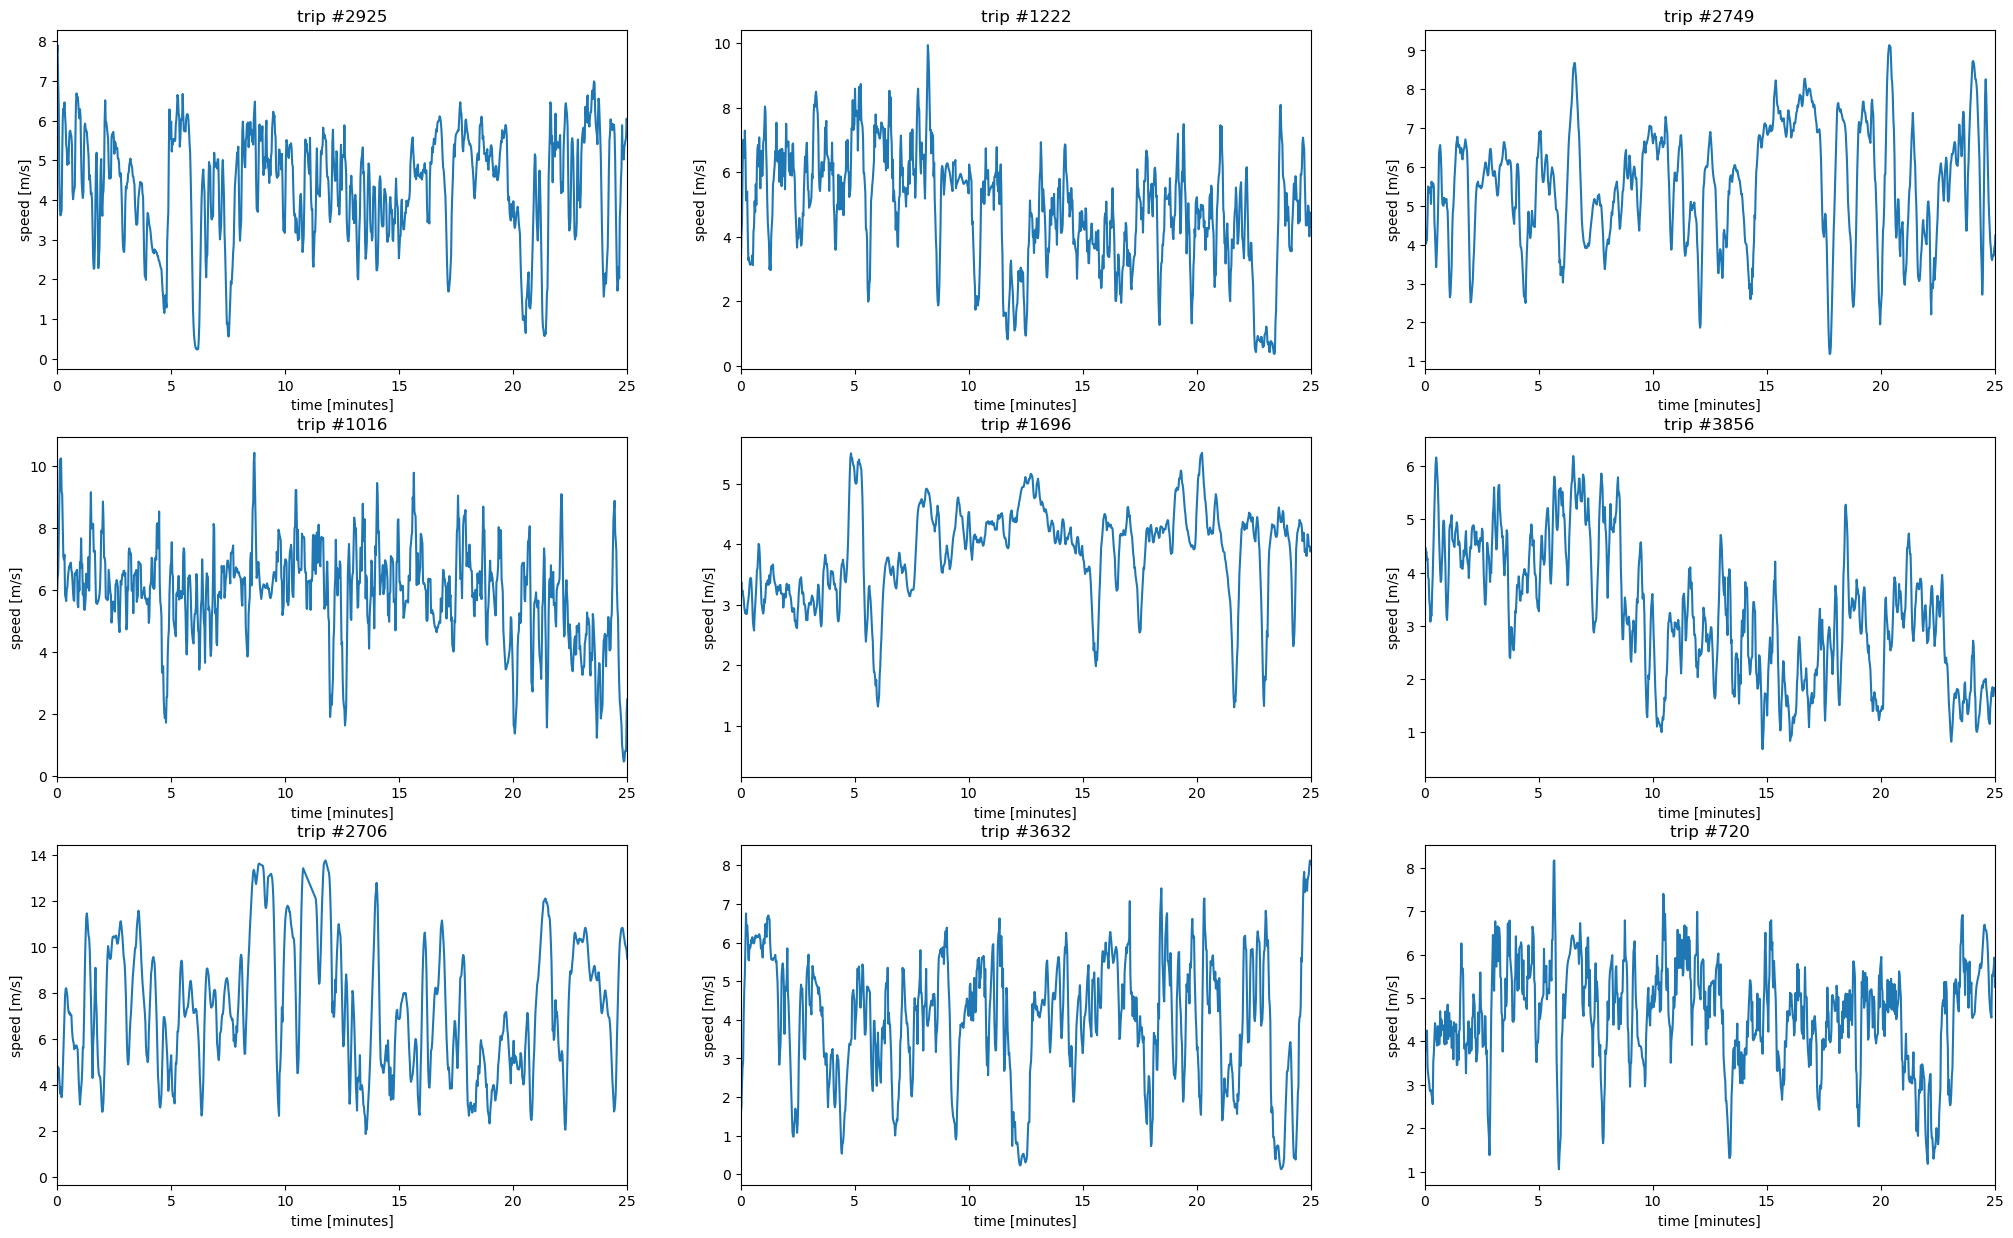

In [1042]:
N = 9

trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 25])
    plt.title("trip #"+str(trip))

plt.show()

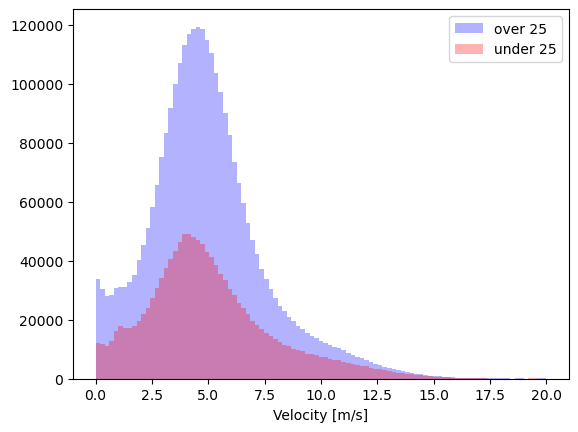

In [1183]:
bins = np.linspace(0, 20, 100) 
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]>=25)]["vel"], label='over 25', bins=bins, alpha=0.3, color='blue')
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]<=25)]["vel"], label='under 25', bins=bins, alpha=0.3, color='red')

plt.xlabel("Velocity [m/s]")
plt.legend()
 
plt.show()

# discarded: 
cruising band

In [ ]:
V = opt_df["vel_smooth"].tolist()
cale = []
idx_cale = []

for i in range(len(V)):
    v_list = []
    idx_li = []
    v = V[i]
    for j in range(i,len(V)):
        u = V[j]
        if u < v*1.07 and u > v*0.93:
            v_list.append(u)
            idx_li.append(j)
        else:
            if len(v_list) >= 5:
                cale.append(v_list)
                idx_cale.append(idx_li)
                #for el in idx_li:
                #    if el != idx_cale:
                #        idx_cale.append(el)
            break
            
idx_uni = []
col_idx = [0 for x in range(len(opt_df))]


for i in range(len(cale)):
    for el in idx_cale[i]:
        if el not in idx_uni:
            idx_uni.append(el)
            col_idx[el] = 1

In [1554]:
GM["vel_og"].nlargest(5).tolist()

[20810.848451920672,
 11695.70972129774,
 10889.140153554534,
 6986.671349271392,
 5407.8720125423315]

In [1555]:
GM.mean()

/var/folders/3q/ktwh6dvs5b54vx_b6719ylx80000gn/T/ipykernel_2314/102902775.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  GM.mean()


trip_id            2057.869710
length                8.234827
time                  1.510000
vel_og                5.453528
Z_val_20              5.109268
vel                   4.986704
vel_smooth            4.979099
count              1106.381932
total_time           55.937020
acc                  -0.000458
acc_smooth           -0.000038
vel_smooth_test       4.986703
acc_smooth_test      -0.000328
acc_og               -0.000517
time_sum             27.843945
dtype: float64